# General Dependencies

In [1]:
import torch
# pip uninstall torch torchvision -y
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129 INSTALL WITH CUDA INDEX look in google for pytorch start locally
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070 Ti


In [2]:
__file__ = "D:/GitHub/UmAutoplay/dev_play.ipynb"

In [3]:
from pathlib import Path
from core.settings import Settings
from core.utils.logger import setup_uma_logging, logger_uma

param_imgsz=832
param_conf=0.65
param_iou=0.45


PROJECT_ROOT = Path(__file__).resolve().parents[0]  # adjust to your repo root
setup_uma_logging(debug=True, show_func=False)
logger_uma.info("WORKING!")

16:58:13 INFO    1204325400.py:12: WORKING!


# Setup

In [4]:
from time import sleep

from core.controllers.bluestacks import BlueStacksController
from core.controllers.steam import SteamController
from core.controllers.android import ScrcpyController

ctrl = SteamController("Umamusume", capture_client_only=True)
# ctrl = ScrcpyController(window_title="23117RA68G")
# ctrl = BlueStacksController("BlueStacks App Player")

In [5]:
from core.perception.ocr.ocr_local import LocalOCREngine

# Forcing USE_FAST_OCR=True to debug
ocr = LocalOCREngine(
    text_detection_model_name="PP-OCRv5_mobile_det",
    text_recognition_model_name="en_PP-OCRv5_mobile_rec",
)

c:\Users\magod\Anaconda3\envs\env_uma\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
Creating model: ('PP-OCRv5_mobile_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\PP-OCRv5_mobile_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\magod\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


16:58:20 INFO    ocr_local.py:146: OCRInterface initialized | lang=en device=cpu


In [6]:
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.utils.waiter import Waiter,PollConfig
yolo_engine = LocalYOLOEngine(
    ctrl=ctrl,
    weights=Settings.YOLO_WEIGHTS_UNITY_CUP,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV, Settings.YOLO_WEIGHTS_UNITY_CUP
)
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

16:58:20 INFO    yolo_local.py:35: Loading YOLO weights from: D:\GitHub\UmAutoplay\models\uma_unity_cup.pt
16:58:20 DEBUG   waiter.py:64: [waiter] init agent=player tag=player


# Lookup

## Real Time

13:49:57 DEBUG   1983268793.py:105: Screen Detection: Training | {'training_buttons': 5}


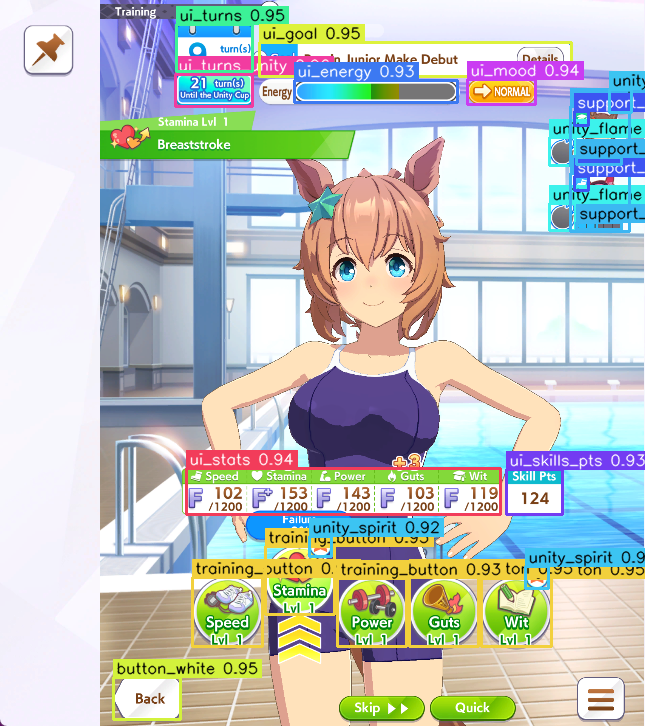

00 | ui_turns_unity       | conf=0.957 | xyxy=(175.6,74.3,252.0,106.2)
01 | ui_turns             | conf=0.954 | xyxy=(176.4,24.6,252.3,71.1)
02 | training_button      | conf=0.954 | xyxy=(481.1,578.1,551.1,646.3)
03 | ui_goal              | conf=0.952 | xyxy=(259.9,42.7,571.7,76.4)
04 | button_white         | conf=0.951 | xyxy=(113.8,677.5,180.1,719.7)
05 | training_button      | conf=0.945 | xyxy=(409.2,577.7,478.6,646.1)
06 | ui_mood              | conf=0.942 | xyxy=(467.4,79.3,535.8,104.3)
07 | unity_flame          | conf=0.941 | xyxy=(549.5,203.1,575.4,230.5)
08 | training_button      | conf=0.939 | xyxy=(193.0,577.7,262.8,646.2)
09 | unity_flame          | conf=0.937 | xyxy=(549.6,137.5,575.5,165.4)
10 | ui_stats             | conf=0.935 | xyxy=(186.8,468.4,500.8,514.3)
11 | training_button      | conf=0.932 | xyxy=(337.0,578.2,406.8,646.1)
12 | ui_skills_pts        | conf=0.930 | xyxy=(506.5,469.9,562.9,514.5)
13 | ui_energy            | conf=0.929 | xyxy=(294.5,80.8,457.9,102.6)

In [22]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------

assert ctrl.focus()

# NEW: recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=param_imgsz,
    conf=0.61,
    iou=param_iou,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


## Static

In [ ]:
from core.perception.analyzers.screen import classify_screen
from core.utils.img import bgr_to_pil, shrink
from core.utils.logger import logger_uma

import cv2
import numpy as np
import hashlib
import colorsys

def overlay_dets_to_bgr(
    pil_img,
    dets,
    *,
    box_color=(0, 255, 0),
    text_color=None,
    class_color_map=None,  # Optional: {'class_name': (B,G,R)}
):
    """
    Draw detection rectangles + labels on a copy of the PIL image, return BGR np.ndarray.
    `dets` is a list of DetectionDict: {"name": str, "conf": float, "xyxy": (x1,y1,x2,y2), "idx": int}
    - Each class gets its own color (stable across runs) unless overridden by `class_color_map`.
    - Text color is auto-selected (black/white) for contrast unless `text_color` is provided.
    """
    # PIL (RGB) -> BGR
    rgb = np.array(pil_img)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    def _stable_bgr_for_key(key: str) -> tuple[int, int, int]:
        """Generate a stable, distinct BGR color from a string key."""
        # Stable hash → hue [0, 360)
        h = int(hashlib.md5(key.encode("utf-8")).hexdigest()[:8], 16) % 360
        h /= 360.0
        s, v = 0.75, 0.95  # fairly vivid but not neon
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return int(b * 255), int(g * 255), int(r * 255)  # RGB→BGR

    def _auto_text_bgr(bg_bgr: tuple[int, int, int]) -> tuple[int, int, int]:
        b, g, r = bg_bgr
        # Relative luminance (sRGB) to pick white/black for legibility
        y = 0.2126 * r + 0.7152 * g + 0.0722 * b
        return (255, 255, 255) if y < 140 else (0, 0, 0)

    for d in dets or []:
        x1, y1, x2, y2 = map(int, d.get("xyxy", (0, 0, 0, 0)))
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        label = f"{name} {conf:.2f}"

        # Choose per-class color:
        if class_color_map and name in class_color_map:
            this_box = class_color_map[name]
        else:
            # Use class name if available; else fall back to idx for stability
            key = name if name != "?" else str(d.get("idx", name))
            this_box = _stable_bgr_for_key(key)

        # Draw box
        cv2.rectangle(bgr, (x1, y1), (x2, y2), this_box, 2)

        # Draw label background
        (tw, th), bl = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        by1 = max(y1 - th - 6, 0)
        bx2 = min(x1 + tw + 6, bgr.shape[1] - 1)
        cv2.rectangle(bgr, (x1, by1), (bx2, by1 + th + 6), this_box, -1)

        # Text color (auto unless provided)
        tc = text_color if text_color is not None else _auto_text_bgr(this_box)

        # Draw text
        cv2.putText(
            bgr,
            label,
            (x1 + 3, by1 + th + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            tc,
            1,
            cv2.LINE_AA,
        )

    return bgr


# ---------------- your flow ----------------
from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from PIL import Image

"tests/data/events/event_support_kitasan_paying_it_forward.png"
img = Image.open("temp/bug1.png").convert("RGB")
ctrl_static = StaticImageController(img)
yolo_engine_static = LocalYOLOEngine(
    ctrl=ctrl_static,
    weights=Settings.YOLO_WEIGHTS,  # Settings.YOLO_WEIGHTS, Settings.YOLO_WEIGHTS_NAV
)


assert ctrl_static.focus()

# recognize() returns (pil_image, meta_dict, dets_list)
game_img, meta, parsed_objects_screen = yolo_engine_static.recognize(
    imgsz=832,
    conf=0.1,
    iou=0.45,
    tag="general",
)

screen, info = classify_screen(
    parsed_objects_screen,
    lobby_conf=0.60,
    require_infirmary=True,   # set False if you want to allow tazuna-only
    training_conf=0.50,
    event_conf=0.60,
    names_map=None,           # or override class names here
)

logger_uma.debug(f"Screen Detection: {screen} | {info}")

# 3) visualize (now we draw overlays ourselves)
annot_bgr = overlay_dets_to_bgr(game_img, parsed_objects_screen)
display(bgr_to_pil(shrink(annot_bgr, 700)))

# 4) print raw detections
if not parsed_objects_screen:
    print("No detections.")
else:
    for i, d in enumerate(parsed_objects_screen):
        name = str(d.get("name", "?"))
        conf = float(d.get("conf", 0.0))
        x1, y1, x2, y2 = map(float, d.get("xyxy", (0, 0, 0, 0)))
        print(f"{i:02d} | {name:20s} | conf={conf:0.3f} | xyxy=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


In [ ]:
# Save segment
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Literal
from PIL import Image

def _clamp_box(x1: int, y1: int, x2: int, y2: int, w: int, h: int) -> Tuple[int, int, int, int]:
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    # Ensure x2>x1 and y2>y1 (at least 1px box)
    if x2 <= x1: x2 = min(w - 1, x1 + 1)
    if y2 <= y1: y2 = min(h - 1, y1 + 1)
    return x1, y1, x2, y2

def _expand_box(x1: int, y1: int, x2: int, y2: int,
                w: int, h: int,
                pad_px: int = 0,
                pad_pct: float = 0.0) -> Tuple[int, int, int, int]:
    bw = max(1, x2 - x1)
    bh = max(1, y2 - y1)
    px = pad_px + int(bw * pad_pct)
    py = pad_px + int(bh * pad_pct)
    return _clamp_box(x1 - px, y1 - py, x2 + px, y2 + py, w, h)

def crop_by_class(
    pil_img: Image.Image,
    dets: List[Dict],
    class_name: str,
    out_dir: str,
    *,
    conf_min: float = 0.0,
    mode: Literal["best","all","index"] = "best",
    index: Optional[int] = None,          # used when mode="index" (0-based within filtered list)
    pad_px: int = 0,
    pad_pct: float = 0.0,                 # e.g. 0.05 → +5% of box size on all sides
    prefix: Optional[str] = None,
    fmt: str = "png",                     # "png" or "jpg"
) -> List[Tuple[str, Image.Image, Dict]]:
    """
    Find detections with name == class_name and save crops to `out_dir`.

    Returns a list of (saved_path, crop_image, det_dict) in the order saved.
    If nothing matches, returns [].

    - mode="best": only highest-confidence match
      mode="index": only the Nth match after sorting by confidence (index required)
      mode="all": save all matches (sorted by confidence desc)
    """
    # Filter & sort candidates
    cands = [d for d in (dets or []) if str(d.get("name","")) == class_name and float(d.get("conf",0.0)) >= conf_min]
    cands.sort(key=lambda d: float(d.get("conf", 0.0)), reverse=True)

    if not cands:
        return []

    if mode == "best":
        chosen = [cands[0]]
    elif mode == "index":
        if index is None or index < 0 or index >= len(cands):
            return []
        chosen = [cands[index]]
    else:  # "all"
        chosen = cands

    # Prepare output
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    w, h = pil_img.size

    results: List[Tuple[str, Image.Image, Dict]] = []
    for rank, d in enumerate(chosen):
        x1, y1, x2, y2 = d.get("xyxy", (0,0,0,0))
        # Round to ints
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        # Optional padding and clamp
        x1, y1, x2, y2 = _expand_box(x1, y1, x2, y2, w, h, pad_px=pad_px, pad_pct=pad_pct)

        crop = pil_img.crop((x1, y1, x2, y2))

        base = prefix or class_name
        conf = float(d.get("conf", 0.0))
        # e.g. ui_energy_rank0_0.95_0348-0090-0622-0132.png
        fname = f"{base}_rank{rank}_{conf:.2f}_{x1:04d}-{y1:04d}-{x2:04d}-{y2:04d}.{fmt.lower()}"
        save_path = str(out_path / fname)
        # Save with sane defaults
        save_kwargs = {}
        if fmt.lower() == "jpg":
            save_kwargs.update({"quality": 95, "optimize": True})
        crop.save(save_path, **save_kwargs)

        results.append((save_path, crop, d))

    return results

_ = crop_by_class(
    game_img,
    parsed_objects_screen,
    class_name="event_card",
    out_dir="assets",
    conf_min=0.60,
    mode="best",
    pad_pct=0.01,   # add ~X% padding for safety
)


# Segment by segment testing

## Lobby

In [8]:
# core/actions/unity_cup/lobby.py
from __future__ import annotations


from core.actions.lobby import LobbyFlow
from core.constants import UNITY_TURNS_CLASS
from core.controllers.base import IController
from core.perception.extractors.state import (
    extract_mood,
    extract_infirmary_on,
    extract_skill_points,
    extract_goal_text,
    extract_energy_pct,
    extract_turns,
    find_best,
)
from core.perception.yolo.interface import IDetector
from core.utils.logger import logger_uma
from core.utils.race_index import date_key_from_dateinfo
from core.utils.waiter import Waiter
from core.utils.yolo_objects import collect

from core.utils.date_uma import (
    is_summer_in_two_or_less_turns,
    date_is_confident,
)

class LobbyFlowUnityCup(LobbyFlow):
    """
    Encapsulates all Lobby decisions & navigation.
    Composes RaceFlow and centralizes waits via a single Waiter.
    """

    def __init__(
        self,
        ctrl: IController,
        ocr,
        yolo_engine: IDetector,
        waiter: Waiter,
        *,
        minimum_skill_pts: int = 500,
        auto_rest_minimum: int = 24,
        prioritize_g1: bool = False,
        process_on_demand=True,
        interval_stats_refresh=1,
        max_critical_turn=8,
        plan_races={},
    ) -> None:
        super().__init__(
            ctrl,
            ocr,
            yolo_engine,
            waiter,
            minimum_skill_pts=minimum_skill_pts,
            auto_rest_minimum=auto_rest_minimum,
            prioritize_g1=prioritize_g1,
            process_on_demand=process_on_demand,
            interval_stats_refresh=interval_stats_refresh,
            max_critical_turn=max_critical_turn,
            plan_races=plan_races,
            date_layout="right",
        )

    # --------------------------
    # Public entry point
    # --------------------------
    def process_turn(self):
        """
        Evaluate the Lobby and take the next action.
        Returns a short outcome string:
          - "RACED"          → we entered/finished a race flow
          - "INFIRMARY"      → we went to infirmary
          - "RESTED"         → we chose rest/recreation
          - "TO_TRAINING"    → we navigated to the training screen
          - "CONTINUE"       → we did a minor click or nothing

        optional extra message
        """
        img, dets = collect(
            self.yolo_engine,
            imgsz=self.waiter.cfg.imgsz,
            conf=self.waiter.cfg.conf,
            iou=self.waiter.cfg.iou,
            tag="lobby_state",
        )

        if not self.process_on_demand:
            self._update_state(
                img, dets
            )  # -> Very expensive, calculate as you need better

        # --- Critical goal logic & early racing opportunities ---

        if self.process_on_demand:
            self._process_date_info(img, dets)
            logger_uma.info(
                f"Date: {self.state.date_info} | raw: {self.state.career_date_raw}"
            )

        if self.process_on_demand:
            self.state.energy = extract_energy_pct(img, dets)

        # --- Race planning (explicit list takes precedence; else G1 if available) ---
        self._plan_race_today()

        current_date_key = (
            date_key_from_dateinfo(self.state.date_info)
            if self.state and getattr(self.state, "date_info", None)
            else None
        )
        if (
            self._skip_race_once
            and self._skip_guard_key
            and current_date_key
            and current_date_key != self._skip_guard_key
        ):
            logger_uma.info(
                "[planned_race] skip guard released: %s -> %s",
                self._skip_guard_key,
                current_date_key,
            )
            self._skip_race_once = False
            self._skip_guard_key = None

        # If we have a planned race today, go race (subject to early-guard rules)
        if self.state.planned_race_name:
            # First-Junior-Day guard (no races available there)
            is_first_junior_date = (
                bool(self.state.date_info)
                and date_is_confident(self.state.date_info)
                and self.state.date_info.year_code == 1
                and self.state.date_info.month == 7
                and self.state.date_info.half == 1
            )
            guard_extra = {
                "first_junior": is_first_junior_date,
                "skip_guard": self._skip_race_once,
            }
            self._log_planned_race_decision(
                action="guard_evaluate",
                plan_name=self.state.planned_race_name,
                extra=guard_extra,
            )
            if not is_first_junior_date and not self._skip_race_once:
                reason = f"Planned race: {self.state.planned_race_name}"
                self._log_planned_race_decision(
                    action="enter_race",
                    plan_name=self.state.planned_race_name,
                    reason="guard_passed",
                    extra=guard_extra,
                )
                self._skip_race_once = False
                return "TO_RACE", reason
            else:
                suppression_reasons = []
                if is_first_junior_date:
                    suppression_reasons.append("first_junior_date")
                if self._skip_race_once:
                    suppression_reasons.append("skip_guard")
                self._log_planned_race_decision(
                    action="guard_suppressed",
                    plan_name=self.state.planned_race_name,
                    reason=",".join(suppression_reasons) or "unknown",
                    extra=guard_extra,
                )
                logger_uma.debug(
                    "[lobby] Planned race suppressed by first-junior-day/skip flag."
                )
            self._skip_race_once = False
            self._skip_guard_key = None

        if self.process_on_demand:
            self._process_turns_left(img, dets)
            self._process_turns_special(img, dets)

        if self.state.turn <= self.max_critical_turn:
            if not self._skip_race_once and self.state.energy is not None and self.state.energy > 2:
                # [Optimization] 10 steps for goal, or unknown turns or -1 turns, check goal
                outcome_bool, reason = self._maybe_do_goal_race(img, dets)
                if outcome_bool:
                    return "TO_RACE", reason

        # After special-case goal racing, clear the one-shot skip guard.
        self._skip_race_once = False

        if self.process_on_demand:
            self.state.infirmary_on = extract_infirmary_on(img, dets, threshold=0.60)

        # --- Infirmary handling (only outside summer) ---
        if self.state.infirmary_on and (self.state.is_summer is False):
            if self._go_infirmary():
                return "INFIRMARY", "Infirmary to remove blue condition"

        # --- Energy management (rest) ---
        if self.state.energy is not None:
            if self.state.energy <= self.auto_rest_minimum:
                reason = f"Energy too low, resting: auto_rest_minimum={self.auto_rest_minimum}"
                if self._go_rest(reason=reason):
                    return "RESTED", reason
            elif (
                self.state.energy <= 50
                and self.state.date_info
                and is_summer_in_two_or_less_turns(self.state.date_info)
            ):
                reason = "Resting to prepare for summer"
                if self._go_rest(reason=reason):
                    return "RESTED", reason

        if self.process_on_demand:
            self.state.mood = extract_mood(self.ocr, img, dets, conf_min=0.3)

        if self.state.mood[-1] < 0:
            logger_uma.warning("UNKNOWN mood!")
        # --- Mood (for training policy)---
        # Navigate to Training if nothing else

        if self._go_training_screen_from_lobby(img, dets):
            return "TO_TRAINING", "No critical stuff going to train"

        return "CONTINUE", "Unknown"

    def _update_state(self, img, dets) -> None:
        # Skill points, goal & energy
        self.state.skill_pts = extract_skill_points(self.ocr, img, dets)
        self.state.goal = extract_goal_text(self.ocr, img, dets)
        self.state.energy = extract_energy_pct(img, dets)

        self._update_stats(img, dets)
        # Turns & career date parsing
        self._process_turns_left(img, dets)
        self._process_turns_special(img, dets)
        self._process_date_info(img, dets)
        # Infirmary & mood
        self.state.infirmary_on = extract_infirmary_on(img, dets, threshold=0.60)
        self.state.mood = extract_mood(self.ocr, img, dets, conf_min=0.3)

    def _process_turns_left(self, img, dets):

        new_turn = extract_turns(self.ocr, img, dets, add_gap_y2=False)
        if new_turn != -1:
            ref_turn = self.last_turns_left_prediction or self.state.turn or -1
            diff = abs(ref_turn - new_turn)
            if diff < 5 or ref_turn == -1 or self.state.turn <= 2:
                # accept only if new change is not too big, or if last detected turn was near to finish turns left
                self.state.turn = new_turn
            elif self.state.turn > 1:
                logger_uma.debug(
                    f"Naive prediction. Last turn was: {self.state.turn}, so now it should be at most {self.state.turn - 1}"
                )
                self.state.turn -= 1
        elif self.state.turn > 0:
            # Naive prediction
            logger_uma.debug(
                f"Naive prediction. Last turn was: {self.state.turn}, so now it should be at most {self.state.turn - 1}"
            )
            self.state.turn -= 1
        self.last_turns_left_prediction = new_turn

    def _process_turns_special(self, img, dets):
        new_turns_special = extract_turns(
            self.ocr,
            img,
            dets,
            turns_class=UNITY_TURNS_CLASS,
            add_gap_y1=False, add_gap_y2=False
        )

        if new_turns_special != -1:
            ref_turns_special = (
                getattr(self, "last_turns_special_prediction", None)
                or self.state.turns_special
                or -1
            )
            diff_special = abs(ref_turns_special - new_turns_special)

            if diff_special < 5 or ref_turns_special == -1 or self.state.turns_special <= 2:
                self.state.turns_special = new_turns_special
            elif self.state.turns_special > 1:
                logger_uma.debug(
                    "[turns_special] Naive prediction. Last value was %s, so now it "
                    "should be at most %s",
                    self.state.turns_special,
                    self.state.turns_special - 1,
                )
                self.state.turns_special -= 1
        elif self.state.turns_special > 0:
            logger_uma.debug(
                "[turns_special] Naive prediction. Last value was %s, so now it should "
                "be at most %s",
                self.state.turns_special,
                self.state.turns_special - 1,
            )
            self.state.turns_special -= 1

        self.last_turns_special_prediction = new_turns_special


In [9]:
assert ctrl.focus()
lobby = LobbyFlowUnityCup(
    ctrl,
    ocr,
    yolo_engine,
    waiter,
    # max_critical_turn=13,
    # minimum_skill_pts=minimum_skill_pts,
    # auto_rest_minimum=auto_rest_minimum,
    # prioritize_g1=prioritize_g1,
    # interval_stats_refresh=interval_stats_refresh,
    # plan_races=self.plan_races,
)

## MOCK
img, dets = collect(
    lobby.yolo_engine,
    imgsz=lobby.waiter.cfg.imgsz,
    conf=lobby.waiter.cfg.conf,
    iou=lobby.waiter.cfg.iou,
    tag="lobby_state",
)
res_turn = lobby.process_turn()
print(res_turn)
print(lobby.state)
# lobby._update_turns_special(img, dets)

13:15:01 DEBUG   lobby.py:639: [date] prev: None. Cand: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None). accepted: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None)
13:15:01 INFO    lobby.py:640: [date] initial: None -> Y1
13:15:01 INFO    2985971458.py:96: Date: DateInfo(raw='Junior Year Pre-Debut', year_code=1, month=None, half=None) | raw: Junior Year Pre-Debut
13:15:01 WARNING state.py:171: Unrecognized turns
13:15:01 INFO    lobby.py:959: [lobby] No critical actions → go Train
13:15:02 DEBUG   state.py:367: Stat 19 < 90 without trailing letter; treating as unrecognized (raw='19')
13:15:02 DEBUG   lobby.py:394: [stats] imputed ['WIT'] with avg=119
13:15:02 INFO    lobby.py:411: [stats] update: SPD:-1->96, STA:-1->146, PWR:-1->140, GUTS:-1->93
('TO_TRAINING', 'No critical stuff going to train')
LobbyState(goal=None, energy=95, skill_pts=0, infirmary_on=False, turn=11, turns_special=-1, career_date_raw='Junior Year Pre-Debut', date_in

## Skills

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

skills_flow = SkillsFlow(ctrl, ocr, yolo_engine, waiter)
skills_flow.buy(skill_list=[
    "Focus"
])


## Races

In [ ]:
race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
race_flow.run(desired_race_name="Oro Cup", date_key="Y3-11-1")
# race_flow.run(desired_race_name="JBC Ladies' Classic", date_key="Y3-11-1")

In [ ]:
from core.controllers.steam import SteamController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))

ctrl = SteamController("Umamusume", capture_client_only=True)
assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

race_flow = RaceFlow(ctrl, ocr, yolo_engine, waiter)
# race_flow._ensure_in_raceday()
# race_flow.run(ensure_navigation=False, select_style="pace")
race_flow.lobby()

## Events

In [7]:
# 🔧 Build (re-run only when you change datasets or add new images)
# from core.utils.event_processor import build_catalog

from IPython.display import display
from PIL import Image
import json

def show_image(path, title=None, max_size=160):
    if not path:
        print("(no image)")
        return
    try:
        im = Image.open(path).convert("RGB")
        # shrink for notebook
        w, h = im.size
        scale = min(max_size / max(w, h), 1.0)
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)))
        if title:
            print(title)
        display(im)
    except Exception as e:
        print(f"[show_image] failed: {e} | path={path}")

def preview_option(rec, pick):
    opts = rec.options or {}
    items = opts.get(str(pick), [])
    if not items:
        print(f"(no data for option {pick})")
        return
    print(f"First outcome for option {pick}:")
    print(json.dumps(items[0], ensure_ascii=False, indent=2))


print("Building catalog…")
build_catalog()

Building catalog…
[build_catalog] Wrote 907 events → datasets\in_game\event_catalog.json


In [ ]:
# 🔁 Load catalog & prefs into memory (kept in notebook state)
from core.utils.event_processor import CATALOG_JSON, Catalog, UserPrefs

cat = Catalog.load(CATALOG_JSON)

In [ ]:
# from core.utils.event_processor import Query, retrieve_best


ocr_title = "Just an Acupuncturist, No Worries!"

portrait_crop = "temp/Kitasan Black_SSR.png"

q = Query(
    ocr_title=ocr_title,
    # type_hint="support",            # support | trainee | scenario
    # name_hint="Kitasan Black",      # optional
    # rarity_hint="R",              # optional
    # portrait_path=portrait_crop,
    # chain_step_hint=2,   # tell the retriever which chain step you’re seeing
)

candidates = retrieve_best(cat, q, top_k=5, min_score=0.1)
for i, r in enumerate(candidates, 1):
    print(f"{i:>2}. {r.rec.key:80s} | score={r.score:.3f}  "
          f"(text={r.text_sim:.3f} img={r.img_sim:.3f} bonus={r.hint_bonus:.3f})")

best = candidates[0]
print("\nBest match:", best.rec.key)
pick = prefs.pick_for(best.rec)
print("Resolved option (with prefs):", pick)
preview_option(best.rec, pick)
show_image(best.rec.image_path, title="Matched catalog image")


In [ ]:
from core.utils.img import to_bgr


deck = [
    {"name": "Kitasan Black", "rarity": "SSR", "attribute": "SPD"},
    {"name": "Gold Ship", "rarity": "SSR", "attribute": "STA"},
    {"name": "Matikanetannhauser", "rarity": "SSR", "attribute": "GUTS"},
    {"name": "Tokai Teio", "rarity": "SSR", "attribute": "SPD"},
    {"name": "Tazuna Hayakawa", "rarity": "SSR", "attribute": "PAL"},
    {"name": "Nishino Flower", "rarity": "SSR", "attribute": "WIT"},
]

# "./temp/hints/hint_kitasan.png"
image_path = "./temp/hints/hint_kitasan.png"
crop_bgr = to_bgr(image_path)
matcher = get_support_matcher(deck or Settings.SUPPORT_DECK, min_confidence=0.25)
match = matcher.best_match(crop_bgr)
print(match)


TemplateMatch(name='Kitasan Black', score=0.47795045055269236, tm_score=0.42113966494798655, hash_score=0.59375, hist_score=0.6440268508910174, path='web\\public\\events\\support_icon_training\\Kitasan Black.png', metadata={'name': 'Kitasan Black', 'rarity': 'SSR', 'attribute': 'SPD'})


## Training policy

In [10]:
# core\utils\training_check_helpers.py
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np
from PIL import Image
import cv2
import time
from core.perception.extractors.training_metrics import extract_failure_pct_for_tile
from core.perception.unity_cup_spirit_classifier import UnityCupSpiritClassifier
from core.settings import Settings

from core.perception.analyzers.hint import (
    assign_hints_to_supports,
    build_support_geometries,
)

from core.utils.logger import logger_uma
from core.utils.analyzers import analyze_support_crop
from core.utils.support_matching import (
    get_card_priority,
    get_runtime_support_matcher,
    match_support_crop,
)

SUPPORT_NAMES = {
    "support_card",
    "support_card_rainbow",
    "support_etsuko",
    "support_director",
    "support_tazuna",
    "support_kashimoto",
}

# -------- helpers --------
def _center_x(xyxy):
    x1, _, x2, _ = xyxy
    return 0.5 * (x1 + x2)

def _center(xyxy: Tuple[float, float, float, float]) -> Tuple[float, float]:
    x1, y1, x2, y2 = xyxy
    return (0.5 * (x1 + x2), 0.5 * (y1 + y2))

def get_buttons_ltr(parsed_objs: List[Dict]) -> List[Dict]:
    btns = [d for d in parsed_objs if d["name"] == "training_button"]
    btns.sort(key=lambda d: _center_x(d["xyxy"]))
    return btns

def raised_training_ltr_index(
    parsed: List[Dict], tol_px: int = 3, tol_frac_h: float = 0.06
) -> Optional[int]:
    btns = [d for d in parsed if d["name"] == "training_button"]
    if len(btns) < 2:
        return None
    tops = np.array([d["xyxy"][1] for d in btns], dtype=float)
    heights = np.array([d["xyxy"][3] - d["xyxy"][1] for d in btns], dtype=float)
    med_top = float(np.median(tops))
    min_top = float(np.min(tops))
    thr = max(float(tol_px), float(tol_frac_h) * float(np.median(heights)))
    if (med_top - min_top) > thr:
        xs = np.array(
            [(d["xyxy"][0] + d["xyxy"][2]) * 0.5 for d in btns], dtype=float
        )
        order = np.argsort(xs)
        btns_ltr = [btns[i] for i in order]
        tops_ltr = [b["xyxy"][1] for b in btns_ltr]
        return int(np.argmin(tops_ltr))
    return None

def reindex_left_to_right(rows: List[Dict]) -> List[Dict]:
    """
    Normalize logical tile indices by current on-screen geometry to avoid
    duplicating 'last raised' tiles (e.g., WIT) due to timing/animation.
    """
    # Sort by X and assign 0..N-1 as canonical indices
    rows_sorted = sorted(rows, key=lambda r: float(r.get("tile_center_x", 0.0)))
    for j, r in enumerate(rows_sorted):
        r["tile_idx"] = j
    return rows_sorted

def failure_pct(cur_img, cur_parsed, tile_xyxy, energy, ocr):
    ENERGY_TO_IGNORE_FAILURE = 45
    if energy >= ENERGY_TO_IGNORE_FAILURE:
        return 0

    failure_predict = extract_failure_pct_for_tile(
        cur_img, cur_parsed, tile_xyxy, ocr
    )
    if failure_predict == -1:
        # try again
        time.sleep(0.2)
        failure_predict = extract_failure_pct_for_tile(
            cur_img, cur_parsed, tile_xyxy, ocr
        )

        if failure_predict == -1:
            failure_predict = Settings.MAX_FAILURE + 1

    return failure_predict

def _classify_flame_pose(flx1, fly1, flx2, fly2, geom) -> str:
    """
    Decide 'filling_up' (left badge by portrait) vs 'exploded' (bottom-right bubble).

    We use the flame *center* in normalized support coordinates (rx, ry),
    with permissive windows that allow slight overhang outside [0,1].
    """
    sx1, sy1, sx2, sy2 = geom.bbox
    sw = max(1.0, float(sx2 - sx1))
    sh = max(1.0, float(sy2 - sy1))
    cx = 0.5 * (flx1 + flx2)
    cy = 0.5 * (fly1 + fly2)
    rx = (cx - sx1) / sw
    ry = (cy - sy1) / sh

    # Windows (normalized) for the two poses:
    # - left badge sits roughly around rx ~ [-0.20..0.35], ry ~ [0.15..0.95]
    # - exploded bubble sits around rx ~ [0.55..1.25],  ry ~ [0.45..1.20]
    in_left  = (-0.20 <= rx <= 0.35) and (0.15 <= ry <= 0.95)
    in_right = ( 0.55 <= rx <= 1.25) and (0.45 <= ry <= 1.20)

    if in_right and not in_left:
        return "exploded"
    if in_left and not in_right:
        return "filling_up"

    # Tie-breaker: pick the closer prototype (works if center lands on the border)
    d_left  = (rx - 0.10)**2 + (ry - 0.65)**2
    d_right = (rx - 1.00)**2 + (ry - 0.70)**2
    return "exploded" if d_right < d_left else "filling_up"


_SPIRIT_CLF = None
def _get_spirit_clf():
    """Lazy-load once; safe if the package is missing."""
    global _SPIRIT_CLF
    if _SPIRIT_CLF is None and UnityCupSpiritClassifier is not None:
        try:
            _SPIRIT_CLF = UnityCupSpiritClassifier.load_from_settings()
        except Exception as e:
            logger_uma.warning("UnityCupSpiritClassifier load failed: %s", e)
            _SPIRIT_CLF = None
    return _SPIRIT_CLF

def _classify_spirit_icon(frame_bgr, xyxy, *, threshold: float = 0.51):
    """
    Returns dict with keys: spirit_label ('spirit_blue'|'spirit_white'|'unknown'),
    spirit_color ('blue'|'white'|'unknown'), spirit_confidence (0..1).
    """
    clf = _get_spirit_clf()
    if clf is None or not xyxy:
        return {"spirit_label": "unknown", "spirit_color": "unknown", "spirit_confidence": 0.0}

    x1, y1, x2, y2 = [int(v) for v in xyxy]
    h, w = frame_bgr.shape[:2]
    pad = 2
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(w, x2 + pad); y2 = min(h, y2 + pad)
    if x2 <= x1 or y2 <= y1:
        return {"spirit_label": "unknown", "spirit_color": "unknown", "spirit_confidence": 0.0}

    crop_rgb = cv2.cvtColor(frame_bgr[y1:y2, x1:x2], cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(crop_rgb)

    try:
        pred = clf.predict(pil_img)  # {'pred_label':'spirit_blue', 'confidence':0.97, ...}
        label = str(pred.get("pred_label", "unknown"))
        conf = float(pred.get("confidence", 0.0))
        if conf < threshold:
            label = "unknown"
    except Exception as e:
        logger_uma.debug("Spirit color predict error: %s", e)
        label, conf = "unknown", 0.0

    color = "blue" if label == "spirit_blue" else ("white" if label == "spirit_white" else "unknown")
    return {"spirit_label": label, "spirit_color": color, "spirit_confidence": conf}


def collect_supports_enriched(
    cur_img: Image.Image, cur_parsed: List[Dict], conf_support: float = 0.60
) -> Tuple[List[Dict], bool]:
    """
    Take *all* supports visible in this capture — they correspond to the currently raised tile.
    Enrich each with bar/type pieces, hint, rainbow, etc.
    """
    frame_bgr = cv2.cvtColor(np.array(cur_img), cv2.COLOR_RGB2BGR)

    # --- helpers: IoU + NMS ---
    def _area(xyxy):
        x1, y1, x2, y2 = [float(v) for v in xyxy]
        return max(0.0, x2 - x1) * max(0.0, y2 - y1)

    def _iou(a, b):
        ax1, ay1, ax2, ay2 = [float(v) for v in a]
        bx1, by1, bx2, by2 = [float(v) for v in b]
        ix1, iy1 = max(ax1, bx1), max(ay1, by1)
        ix2, iy2 = min(ax2, bx2), min(ay2, by2)
        iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
        inter = iw * ih
        if inter <= 0.0:
            return 0.0
        ua = _area(a) + _area(b) - inter
        return inter / ua if ua > 0 else 0.0

    def _nms_by_iou(dets, iou_thr=0.50):
        """
        Class-agnostic NMS: keep highest-conf per overlap cluster.
        Each det: {"xyxy":[...], "conf":float, "name":str, ...}
        """
        if not dets:
            return dets
        # sort by confidence DESC (missing conf -> 0.0)
        ordered = sorted(
            dets, key=lambda d: float(d.get("conf", 0.0)), reverse=True
        )
        kept = []
        for d in ordered:
            dx = d.get("xyxy")
            if not dx:
                continue
            drop = False
            for k in kept:
                if _iou(dx, k.get("xyxy")) >= iou_thr:
                    drop = True
                    break

                kc = k.get("xyxy")
                if kc is None:
                    continue

                cx_d, cy_d = _center(dx)
                cx_k, cy_k = _center(kc)

                kx1, ky1, kx2, ky2 = [float(v) for v in kc]
                dx1, dy1, dx2, dy2 = [float(v) for v in dx]

                center_overlap = (
                    kx1 <= cx_d <= kx2
                    and ky1 <= cy_d <= ky2
                ) or (
                    dx1 <= cx_k <= dx2
                    and dy1 <= cy_k <= dy2
                )

                if center_overlap:
                    drop = True
                    break
            if not drop:
                kept.append(d)
        return kept

    # Raw supports filtered by confidence
    supports_raw = [
        d
        for d in cur_parsed
        if d["name"] in SUPPORT_NAMES and d.get("conf", 0.0) >= conf_support
    ]
    # De-duplicate overlaps (e.g., double rainbow hits)
    supports = _nms_by_iou(supports_raw, iou_thr=0.50)
    parts_bar = [d for d in cur_parsed if d["name"] == "support_bar"]
    parts_type = [d for d in cur_parsed if d["name"] == "support_type"]

    # === SPIRIT detections (works like hint, but independent) ===
    conf_spirit = 0.55
    spirits_raw = [d for d in cur_parsed
                   if d["name"] == "unity_spirit" and d.get("conf", 0.0) >= conf_spirit]
    spirits = _nms_by_iou(spirits_raw, iou_thr=0.30)

    # Hint detections (primary source going forward)
    conf_support_hint = 0.55
    hints_raw = [
        d
        for d in cur_parsed
        if d["name"] == "support_hint" and d.get("conf", 0.0) >= conf_support_hint
    ]
    hints = _nms_by_iou(hints_raw, iou_thr=0.30)
    support_geoms = build_support_geometries(supports)

    # === FLAME detections (pose lives near the card; does NOT jump) ===
    conf_flame = 0.55
    flames_raw = [
        d for d in cur_parsed
        if d["name"] == "unity_flame" and d.get("conf", 0.0) >= conf_flame
    ]
    flames = _nms_by_iou(flames_raw, iou_thr=0.30)

    # Reuse the same geometry assignment for both markers
    support_assignments, tile_hints = assign_hints_to_supports(
        support_geoms, hints, canvas_height=frame_bgr.shape[0],
    )
    spirit_assignments, tile_spirits = assign_hints_to_supports(
        support_geoms, spirits, canvas_height=frame_bgr.shape[0],
    )
    # Flames tend to be either at left side of the circular portrait or at the bottom-right
    # of the portrait, sometimes slightly outside the bbox. Use a wider horizontal expansion
    # and extra bottom headroom to catch the 'exploded' bubble that hangs below.
    flame_assignments, tile_flames = assign_hints_to_supports(
        support_geoms,
        flames,
        canvas_height=frame_bgr.shape[0],
        expand_x_frac=0.50,     # allow overhang to left/right
        expand_top_frac=0.20,   # small margin above the portrait
        expand_bottom_frac=0.55 # larger margin below (exploded bubble)
    )

    if tile_spirits:
        logger_uma.debug("[unity_spirit] Tile spirits detected=%d", len(tile_spirits))
    if tile_hints:
        logger_uma.debug("[support_hint] Tile hints detected=%d", len(tile_hints))
    if tile_flames:
        logger_uma.debug("[unity_flame] Tile flames detected=%d", len(tile_flames))

    def _inside(inner, outer, pad=2):
        ix1, iy1, ix2, iy2 = inner
        ox1, oy1, ox2, oy2 = outer
        return (
            ix1 >= ox1 - pad
            and iy1 >= oy1 - pad
            and ix2 <= ox2 + pad
            and iy2 <= oy2 + pad
        )

    min_confidence = 0.25
    matcher: Optional[Any] = None
    has_priority_customization = bool(Settings.SUPPORT_PRIORITIES_HAVE_CUSTOMIZATION)
    custom_priority_keys = Settings.SUPPORT_CUSTOM_PRIORITY_KEYS

    enriched: List[Dict] = []
    any_rainbow = False

    for s, geom in zip(supports, support_geoms):
        x1, y1, x2, y2 = geom.bbox
        crop = frame_bgr[y1:y2, x1:x2].copy()

        # parts within this support
        bar_xyxy = None
        type_xyxy = None
        for pb in parts_bar:
            bx1, by1, bx2, by2 = [int(v) for v in pb["xyxy"]]
            if _inside((bx1, by1, bx2, by2), (x1, y1, x2, y2), pad=1):
                bar_xyxy = (bx1, by1, bx2, by2)
                break
        for pt in parts_type:
            tx1, ty1, tx2, ty2 = [int(v) for v in pt["xyxy"]]
            if _inside((tx1, ty1, tx2, ty2), (x1, y1, x2, y2), pad=1):
                type_xyxy = (tx1, ty1, tx2, ty2)
                break

        bar_crop = (
            None
            if bar_xyxy is None
            else frame_bgr[
                bar_xyxy[1] : bar_xyxy[3], bar_xyxy[0] : bar_xyxy[2]
            ].copy()
        )
        type_crop = (
            None
            if type_xyxy is None
            else frame_bgr[
                type_xyxy[1] : type_xyxy[3], type_xyxy[0] : type_xyxy[2]
            ].copy()
        )

        support_key = geom.key
        assigned_hints = support_assignments.get(support_key, [])
        hint_confidence_max = (
            max((h.get("conf", 0.0) for h in assigned_hints), default=0.0)
            if assigned_hints
            else 0.0
        )

        assigned_spirits = spirit_assignments.get(support_key, [])
        spirit_confidence_max = max((spt.get("conf", 0.0) for spt in assigned_spirits), default=0.0)

        # NEW: classify color of the best spirit box (if any)
        spirit_color = "unknown"
        spirit_label = "unknown"
        spirit_color_conf = 0.0
        if assigned_spirits:
            # pick the highest-conf spirit detection for color classification
            best_spt = max(assigned_spirits, key=lambda d: float(d.get("conf", 0.0)))
            spirit_cls = _classify_spirit_icon(frame_bgr, best_spt.get("xyxy"))
            spirit_label = spirit_cls["spirit_label"]
            spirit_color = spirit_cls["spirit_color"]
            spirit_color_conf = float(spirit_cls["spirit_confidence"])
            
        attrs = analyze_support_crop(
            s["name"],
            crop,
            piece_bar_bgr=bar_crop,
            piece_type_bgr=type_crop,
            hint_sources=assigned_hints,
            hint_confidence_max=hint_confidence_max,
        )

        has_rainbow = s["name"].endswith("_rainbow") or (
            s["name"] == "support_card_rainbow"
        )
        any_rainbow |= has_rainbow

        normalized_name = s["name"].replace("_rainbow", "")

        has_spirit = len(assigned_spirits) > 0
        has_hint_yolo = bool(attrs.get("has_hint_yolo", False))
        has_hint_hsv = bool(attrs.get("has_hint_hsv", False))
        hint_confidence_max = float(attrs.get("hint_confidence_max", 0.0))
        hint_sources = attrs.get("hint_sources", assigned_hints)

        assigned_flames = flame_assignments.get(support_key, [])
        flame_confidence_max = max((f.get("conf", 0.0) for f in assigned_flames), default=0.0)

        has_flame = len(assigned_flames) > 0
        flame_type: Optional[str] = None
        if has_flame:
            # If multiple flames got attached (rare), classify by the highest-conf one
            best = max(assigned_flames, key=lambda f: float(f.get("conf", 0.0)))
            fx1, fy1, fx2, fy2 = [float(v) for v in best.get("xyxy", (0, 0, 0, 0))]
            flame_type = _classify_flame_pose(fx1, fy1, fx2, fy2, geom)

        support_record: Dict[str, Any] = {
            **s,
            "name": normalized_name,
            "support_type": attrs["support_type"],
            "support_type_score": attrs["support_type_score"],
            "friendship_bar": attrs["friendship_bar"],
            "has_hint": bool(attrs.get("has_hint", False)),
            "has_rainbow": bool(has_rainbow),
            "has_hint_yolo": has_hint_yolo,
            "has_hint_hsv": has_hint_hsv,
            "hint_sources": hint_sources,
            "hint_confidence_max": hint_confidence_max,

            # Spirit fields
            "has_spirit": has_spirit,
            "spirit_sources": assigned_spirits,
            "spirit_confidence_max": float(spirit_confidence_max),
            "spirit_label": spirit_label,                 # 'spirit_blue' | 'spirit_white' | 'unknown'
            "spirit_color": spirit_color,                 # 'blue' | 'white' | 'unknown'
            "spirit_color_confidence": spirit_color_conf, # 0..1

            # flame fields
            "has_flame": bool(has_flame),
            "flame_type": flame_type,  # 'filling_up' | 'exploded' | None
            "flame_sources": assigned_flames,
            "flame_confidence_max": float(flame_confidence_max),
        }

        matched_priority_assignments: Dict[
            Tuple[str, str, str], Tuple[float, Dict[str, Any]]
        ] = {}
        def register_priority_match(
            card_key: Tuple[str, str, str],
            *,
            score: float,
            record: Dict[str, Any],
        ) -> bool:
            existing = matched_priority_assignments.get(card_key)
            if existing and existing[0] >= score:
                logger_uma.debug(
                    "[support_match] Duplicate match %s score=%.3f skipped (existing=%.3f)",
                    card_key,
                    score,
                    existing[0],
                )
                return False

            if existing:
                prev_record = existing[1]
                prev_record.pop("matched_card", None)
                prev_record.pop("priority_config", None)
                logger_uma.debug(
                    "[support_match] Reassigning priority match %s old_score=%.3f → new_score=%.3f",
                    card_key,
                    existing[0],
                    score,
                )

            matched_priority_assignments[card_key] = (score, record)
            return True

        if support_record["has_hint"] and has_priority_customization:
            if matcher is None:
                matcher = get_runtime_support_matcher(min_confidence=min_confidence)
            match = match_support_crop(crop, matcher=matcher)
            if match:
                name = match.get("name", "")
                rarity = match.get("rarity", "")
                attribute = match.get("attribute", "")
                support_record["matched_card"] = match
                key = (name, rarity, attribute)
                if key not in custom_priority_keys:
                    logger_uma.debug(
                        "[support_match] Match %s has no custom priority; skipping",
                        key,
                    )
                elif register_priority_match(key, score=float(match.get("score", 0.0)), record=support_record):
                    support_record["priority_config"] = get_card_priority(
                        name,
                        rarity,
                        attribute,
                    )

                    logger_uma.debug(
                        "[support_match] Hint support matched %s (%s/%s) score=%.3f",
                        name,
                        rarity,
                        attribute,
                        match.get("score", 0.0),
                    )
                else:
                    logger_uma.debug(
                        "[support_match] Match %s rejected due to superior assignment",
                        key,
                    )
            else:
                logger_uma.debug("[support_match] No confident match for hint support")

        enriched.append(support_record)

    return enriched, any_rainbow

In [ ]:
from __future__ import annotations

import time
from typing import Dict, List, Optional, Tuple, Union
import random

import numpy as np
from PIL import Image


from core.perception.yolo.interface import IDetector
from core.settings import Settings
from core.types import DetectionDict
from core.utils.geometry import calculate_jitter
from core.utils.logger import logger_uma
from core.utils.skill_memory import SkillMemoryManager
from core.perception.unity_cup_spirit_classifier import UnityCupSpiritClassifier
from typing import Any
from dataclasses import dataclass, asdict

# from core.utils.training_check_helpers import (
#     get_buttons_ltr,
#     _center_x,
#     raised_training_ltr_index,
#     collect_supports_enriched,
#     failure_pct,
#     reindex_left_to_right
# )

# ---- knobs you may want to tweak later (kept here for clarity) ----
GREEDY_THRESHOLD = 2.5  # "pick immediately" threshold (if you use it)
GREEDY_THRESHOLD_UNITY_CUP = 3.5
HIGH_SV_THRESHOLD = 3.5  # when SV >= this, allow risk up to ×RISK_RELAX_FACTOR
RISK_RELAX_FACTOR = 1.5  # e.g., 20% -> 30% when SV is high

# Director scoring by bar color (latest rule you wrote)
DIRECTOR_SCORE_BY_COLOR = {
    "blue": 0.25,  # "blue or less"
    "green": 0.15,
    "orange": 0.10,
    "yellow": 0.00,  # max (or treat is_max as yellow)
    "max": 0.00,  # alias
}

# What counts as blue/green vs orange/max for the standard supports
BLUE_GREEN = {"blue", "green"}
ORANGE_MAX = {"orange", "yellow"}


@dataclass
class TileSV:
    tile_idx: int
    failure_pct: int
    risk_limit_pct: int
    allowed_by_risk: bool
    sv_total: float
    sv_by_type: Dict[str, float]
    greedy_hit: bool
    notes: List[str]

    def as_dict(self) -> Dict[str, Any]:
        d = asdict(self)
        # optional rounding/pretty-printing
        d["sv_total"] = float(f"{d['sv_total']:.2f}")
        d["sv_by_type"] = {k: float(f"{v:.2f}") for k, v in d["sv_by_type"].items()}
        return d

def scan_training_screen(
    ctrl,
    ocr,  # OCRInterface
    yolo_engine: IDetector,
    energy,
    *,
    pause_after_click_range: list = [0.3, 0.4],
) -> Tuple[List[Dict], Image.Image, List[DetectionDict]]:
    """
    Efficient scan:
      • One initial capture.
      • If a tile is already raised, harvest it first (no click).
      • Then click each remaining tile exactly once; after each click:
          - recapture once,
          - refresh button geometry (LTR),
          - collect supports present in that capture (they belong to the raised tile),
          - extract failure%.
    Returns: (training_state, last_img, last_parsed)
    """
    # -------- detector params --------
    param_imgsz = 832
    param_conf = 0.60  # lower than 0.8 so we don't miss support cards
    param_iou = 0.45

    def _jitter_delay():
        if pause_after_click_range and len(pause_after_click_range) >= 2:
            a, b = float(pause_after_click_range[0]), float(pause_after_click_range[1])
            lo, hi = (a, b) if a <= b else (b, a)
            return max(0.0, random.uniform(lo, hi))
        return 0.6

    # -------- 1) Initial capture, wait for button training animations --------
    time.sleep(0.3)
    cur_img, _, cur_parsed = yolo_engine.recognize(
        imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
    )

    btns = get_buttons_ltr(cur_parsed)

    if btns and len(btns) != 5:
        time.sleep(0.5)
        # try again
        cur_img, _, cur_parsed = yolo_engine.recognize(
            imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
        )

        btns = get_buttons_ltr(cur_parsed)
    if not btns:
        logger_uma.warning("No training buttons detected.")
        return [], cur_img, cur_parsed

    # Fixed LTR scaffold
    scan = [
        {
            "tile_idx": j,
            "tile_xyxy": btns[j]["xyxy"],
            "tile_center_x": float(_center_x(btns[j]["xyxy"])),
            "supports": [],
        }
        for j in range(len(btns))
    ]

    processed: set = set()
    results: List[Dict] = []

    # -------- 1.5) FAST_MODE: low-energy fast path (raised + WIT only) --------
    if (
        Settings.FAST_MODE
        and isinstance(energy, (int, float))
        and 0 <= int(energy) <= 35
    ):
        # Identify raised and WIT (last) indices
        ridx_fast = raised_training_ltr_index(cur_parsed)
        last_idx = len(scan) - 1 if len(scan) > 0 else None
        wanted = []
        if ridx_fast is not None and 0 <= ridx_fast < len(scan):
            wanted.append(("raised", ridx_fast))
        if last_idx is not None and (ridx_fast is None or last_idx != ridx_fast):
            wanted.append(("wit", last_idx))

        for tag_kind, idx in wanted:
            tile = scan[idx]
            if tag_kind == "raised":
                supps, any_rainbow = collect_supports_enriched(cur_img, cur_parsed)
                results.append(
                    {
                        **tile,
                        "supports": supps,
                        "has_any_rainbow": any_rainbow,
                        "failure_pct": failure_pct(
                            cur_img, cur_parsed, tile["tile_xyxy"], energy, ocr
                        ),
                        "skipped_click": True,
                    }
                )
            else:
                # Click WIT (last) tile
                ctrl.click_xyxy_center(
                    tile["tile_xyxy"],
                    clicks=1,
                    jitter=calculate_jitter(tile["tile_xyxy"], percentage_offset=0.20),
                )
                time.sleep(_jitter_delay())
                cur_img, _, cur_parsed = yolo_engine.recognize(
                    imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
                )
                # Refresh LTR geometry
                btns_now = [d for d in cur_parsed if d["name"] == "training_button"]
                btns_now.sort(key=lambda d: _center_x(d["xyxy"]))
                if len(btns_now) == len(scan):
                    for j, b in enumerate(btns_now):
                        scan[j]["tile_xyxy"] = b["xyxy"]
                        scan[j]["tile_center_x"] = float(_center_x(b["xyxy"]))
                # Determine effective raised after click
                ridx_now = raised_training_ltr_index(cur_parsed)
                eff_idx = (
                    ridx_now
                    if (ridx_now is not None and 0 <= ridx_now < len(scan))
                    else idx
                )
                eff_tile = scan[eff_idx]
                supps, any_rainbow = collect_supports_enriched(cur_img, cur_parsed)
                results.append(
                    {
                        **eff_tile,
                        "supports": supps,
                        "has_any_rainbow": any_rainbow,
                        "failure_pct": failure_pct(
                            cur_img, cur_parsed, eff_tile["tile_xyxy"], energy, ocr
                        ),
                        "skipped_click": False,
                    }
                )

        # Normalize tile indices by current geometry to prevent duplicates
        results = reindex_left_to_right(results)
        logger_uma.info(
            "FAST MODE: Only analyzing WIT; everything else may have high risk"
        )
        return results, cur_img, cur_parsed

    # -------- 2) Already-raised tile (no click) --------
    ridx = raised_training_ltr_index(cur_parsed)
    if ridx is not None and 0 <= ridx < len(scan):
        tile = scan[ridx]
        supps, any_rainbow = collect_supports_enriched(cur_img, cur_parsed)
        tile_record = {
            **tile,
            "supports": supps,
            "has_any_rainbow": any_rainbow,
            "failure_pct": failure_pct(cur_img, cur_parsed, tile["tile_xyxy"], energy, ocr),
            "skipped_click": True,  # we did not click for the already-raised tile
        }
        results.append(tile_record)
        processed.add(ridx)

        # -------- FAST_MODE: Greedy short-circuit --------
        if Settings.FAST_MODE:
            try:
                # Compute SV for just this tile and check greedy
                sv_rows_one = compute_support_values_dispatch([tile_record])
                if sv_rows_one and sv_rows_one[0].get("greedy_hit", False):
                    notes = sv_rows_one[-1].get("notes", "")
                    logger_uma.info(
                        f"FAST MODE: Found a greedy training option, not analizing nothing more. notes={notes}"
                    )
                    # Return results so far, don't waste time checking other options; caller will act immediately
                    return results, cur_img, cur_parsed
            except Exception as e:
                # Never break scanning on SV errors; just continue
                logger_uma.error(f"Error while checking FAST_MODE greedy SV: {e}")

    # -------- 3) Visit remaining tiles exactly once --------
    for idx in range(len(scan)):
        if idx in processed:
            continue

        tile = scan[idx]
        # Click to raise this tile
        ctrl.click_xyxy_center(
            tile["tile_xyxy"],
            clicks=1,
            jitter=calculate_jitter(tile["tile_xyxy"], percentage_offset=0.20),
        )

        time.sleep(_jitter_delay())

        # Recapture once
        cur_img, _, cur_parsed = yolo_engine.recognize(
            imgsz=param_imgsz, conf=param_conf, iou=param_iou, tag="training"
        )

        # Refresh geometry (LTR) to keep tile_xyxy up-to-date
        btns_now = get_buttons_ltr(cur_parsed)
        if len(btns_now) == len(scan):
            for j, b in enumerate(btns_now):
                scan[j]["tile_xyxy"] = b["xyxy"]
                scan[j]["tile_center_x"] = float(_center_x(b["xyxy"]))
        else:
            logger_uma.warning(
                "Button count changed during scan: expected %d, got %d; keeping previous geometry",
                len(scan),
                len(btns_now),
            )

        # Whichever tile is raised after the click is the effective index
        ridx = raised_training_ltr_index(cur_parsed)
        eff_idx = ridx if (ridx is not None and 0 <= ridx < len(scan)) else idx
        eff_tile = scan[eff_idx]

        supps, any_rainbow = collect_supports_enriched(cur_img, cur_parsed)

        tile_record = {
            **eff_tile,
            "supports": supps,
            "has_any_rainbow": any_rainbow,
            "failure_pct": failure_pct(cur_img, cur_parsed, eff_tile["tile_xyxy"], energy, ocr),
            "skipped_click": False,
        }
        results.append(tile_record)
        processed.add(eff_idx)

        # -------- FAST_MODE: Greedy short-circuit --------
        if Settings.FAST_MODE:
            try:
                # Compute SV for just this tile and check greedy
                sv_rows_one = compute_support_values_dispatch([tile_record])
                if sv_rows_one and sv_rows_one[0].get("greedy_hit", False):
                    notes = sv_rows_one[-1].get("notes", "")
                    logger_uma.info(
                        f"FAST MODE: Found a greedy training option, not analizing nothing more. notes={notes}"
                    )
                    # Return results so far, don't waste time checking other options; caller will act immediately
                    return results, cur_img, cur_parsed
            except Exception as e:
                # Never break scanning on SV errors; just continue
                logger_uma.error(f"Error while checking FAST_MODE greedy SV: {e}")

    # Final normalization: enforce 0..N-1 by on-screen LTR to avoid duplicated WIT/GUTS
    results = reindex_left_to_right(results)
    return results, cur_img, cur_parsed


def compute_support_values(training_state: List[Dict]) -> List[Dict[str, Any]]:
    """
    Compute Support Value (SV) per tile and apply the failure filtering rule.

    Inputs
    ------
    training_state : list[dict]
        Exactly the structure you pasted (each tile has 'supports', 'failure_pct', ...).

    Scoring Rules (as provided)
    ---------------------------
    • Each blue/green gauge support: +1  (per card)
    • If any blue/green support on the tile has a hint: +0.5 once (tile-capped) x2 if HINT_IS_IMPORTANT is True in Settings
    • Rainbow support (FT): +1 per rainbow card
      - Combo bonus: if >=2 rainbous, only add 0.5
    • Orange/Max gauge WITHOUT hint: +0  (no base)
      Orange/Max gauge WITH hint: +0.5 once (tile-capped, even if multiple)  x2 if HINT_IS_IMPORTANT is True in Settings
    • Reporter (support_etsuko): +0.1
    • Director (support_director): color-based
        blue: +0.25, green: +0.15, orange: +0.10, yellow/max: +0
    • Tazuna (support_tazuna): +0.15 (yellow, max). +1 (blue), +0.5 (green, orange)
    Failure rule
    ------------
    Let max_failure = BASE_MAX_FAILURE (20%) by default.
    - If SV < 3.5 → the tile must have failure_pct ≤ max_failure
    - If SV ≥ 3.5 → allow up to min(100, floor(max_failure * 1.5))

    Returns
    -------
    List[dict] with keys:
      - tile_idx, failure_pct, risk_limit_pct, allowed_by_risk
      - sv_total (float)
      - sv_by_type (dict[str,float])    # per support_type aggregation
      - greedy_hit (bool)               # SV ≥ GREEDY_THRESHOLD
      - notes (list[str])               # human-readable breakdown
    """
    out: List[TileSV] = []
    # Skill memory used for conditional hint gating (once required skills are acquired)
    skill_memory = SkillMemoryManager(
        Settings.resolve_skill_memory_path(Settings.ACTIVE_SCENARIO),
        scenario=Settings.ACTIVE_SCENARIO,
    )

    def _canon_skill(name: object) -> str:
        s = str(name or "")
        for sym in ("◎", "○", "×"):
            s = s.replace(sym, "")
        return " ".join(s.split()).strip()

    default_priority_cfg = Settings.default_support_priority()
    default_bluegreen_value = float(default_priority_cfg.get("scoreBlueGreen", 0.75))
    default_orange_value = float(default_priority_cfg.get("scoreOrangeMax", 0.5))

    def _support_label(support: Dict[str, Any]) -> str:
        matched = support.get("matched_card") or {}
        if isinstance(matched, dict) and matched.get("name"):
            name = str(matched.get("name", "")).strip()
            attr = str(matched.get("attribute", "")).strip()
            rarity = str(matched.get("rarity", "")).strip()
            suffix = " / ".join([p for p in (attr, rarity) if p])
            if suffix:
                return f"{name} ({suffix})"
            return name or "support"
        base = str(support.get("name", "support")).strip()
        return base or "support"

    def _hint_candidate_for_support(
        support: Dict[str, Any],
        *,
        color_key: str,
        default_value: float,
        color_desc: str,
    ) -> Tuple[float, Dict[str, Any]]:
        priority_cfg = support.get("priority_config")
        matched_card = support.get("matched_card")
        matched = isinstance(matched_card, dict) and bool(matched_card)
        if not isinstance(priority_cfg, dict):
            priority_cfg = default_priority_cfg
            matched = False
        enabled = bool(priority_cfg.get("enabled", True))
        # Conditional gating: if ALL required skills are already bought, drop hint value to 0
        gated = False
        try:
            req = priority_cfg.get("skillsRequiredForPriority")
            req_list = []
            if isinstance(req, list):
                req_list = [n for n in (_canon_skill(x) for x in req) if n]
            elif isinstance(req, str):
                req_list = [n for n in (_canon_skill(x) for x in str(req).split(",")) if n]
            if req_list:
                gated = all(skill_memory.has_bought(n) for n in req_list)
        except Exception:
            gated = False
        if gated:
            enabled = False
        label = _support_label(support)
        config_value = float(priority_cfg.get(color_key, default_value))
        base_value = config_value if matched else default_value
        important_mult = 3.0 if Settings.HINT_IS_IMPORTANT else 1.0
        effective_value = base_value * important_mult if enabled else 0.0
        meta = {
            "label": label,
            "color_desc": color_desc,
            "enabled": enabled,
            "matched": matched,
            "base_value": base_value,
            "important_mult": important_mult,
            "gated": gated,
        }
        return effective_value, meta

    def _format_hint_note(meta: Dict[str, Any], bonus: float) -> str:
        label = meta["label"]
        color_desc = meta["color_desc"]
        base_value = meta["base_value"]
        source = "priority" if meta["matched"] else "default"
        important_mult = meta.get("important_mult", 1.0)
        note = f"Hint on {label} ({color_desc}): +{bonus:.2f} (base={base_value:.2f} {source}"
        if important_mult != 1.0:
            note += f", important×{important_mult:.1f}"
        note += ")"
        return note

    for tile in training_state:
        idx = int(tile.get("tile_idx", -1))
        failure_pct = int(tile.get("failure_pct", 0) or 0)
        supports = tile.get("supports", []) or []

        sv_total = 0.0
        sv_by_type: Dict[str, float] = {}
        notes: List[str] = []

        # Tile-level caps/flags
        blue_hint_candidates: List[Tuple[float, Dict[str, Any]]] = []
        orange_hint_candidates: List[Tuple[float, Dict[str, Any]]] = []
        hint_disabled_notes: List[str] = []

        # For rainbow combo computation (per type)
        rainbow_count = 0

        # ---- 1) per-support contributions ----
        for s in supports:
            sname = s.get("name", "")
            # stype = s.get("support_type", "unknown") or "unknown"
            bar = s.get("friendship_bar", {}) or {}
            color = str(bar.get("color", "unknown")).lower()
            is_max = bool(bar.get("is_max", False))
            has_hint = bool(s.get("has_hint", False))
            has_rainbow = bool(s.get("has_rainbow", False))
            label = _support_label(s)

            # Normalize 'max' color if flagged
            if is_max and color not in ("yellow", "max"):
                color = "yellow"

            # --- special cameos ---
            if sname == "support_etsuko":  # reporter
                sv_total += 0.1
                sv_by_type["special_reporter"] = (
                    sv_by_type.get("special_reporter", 0.0) + 0.1
                )
                notes.append(f"Reporter ({label}): +0.10")
                continue

            if sname == "support_director":
                # director score depends on color (blue/green/orange/yellow)
                score = DIRECTOR_SCORE_BY_COLOR.get(
                    color, DIRECTOR_SCORE_BY_COLOR.get("yellow", 0.0)
                )
                if score > 0:
                    sv_total += score
                    sv_by_type["special_director"] = (
                        sv_by_type.get("special_director", 0.0) + score
                    )
                    notes.append(f"Director ({label}, {color}): +{score:.2f}")
                else:
                    notes.append(f"Director ({label}, {color}): +0.00")
                continue

            if sname == "support_tazuna":
                # Tazuna score depends on color:
                if color in ("blue", "green"):
                    score = 1.0
                elif color in ("orange", ):
                    score = 0.5
                elif color in ("yellow",) or is_max:
                    score = 0.15
                else:
                    score = 0.0
                
                if score > 0:
                    sv_total += score
                    sv_by_type["special_tazuna"] = (
                        sv_by_type.get("special_tazuna", 0.0) + score
                    )
                    notes.append(f"Tazuna ({label}, {color}): +{score:.2f}")
                else:
                    notes.append(f"Tazuna ({label}, {color}): +0.00")
                continue

            # --- standard support cards (including rainbow variants) ---
            # Rainbow counts as +1 baseline
            if has_rainbow:
                sv_total += 1.0
                notes.append(f"rainbow ({label}): +1.00")
                rainbow_count = rainbow_count + 1
                # Rainbow hint does not add extra beyond standard tile-capped hint rules;
                # we still let hint rules below consider color buckets if needed.
                # (If you want rainbow to bypass color gates, keep as-is)

            # Blue/green baseline
            if color in BLUE_GREEN:
                sv_total += 1.0
                sv_by_type["cards"] = sv_by_type.get("cards", 0.0) + 1.0
                notes.append(f"{label} {color}: +1.00")
                if has_hint:
                    bonus, meta = _hint_candidate_for_support(
                        s,
                        color_key="scoreBlueGreen",
                        default_value=default_bluegreen_value,
                        color_desc="blue/green",
                    )
                    if not meta["enabled"]:
                        hint_disabled_notes.append(
                            f"Hint on {meta['label']} ({meta['color_desc']}): skipped (priority disabled)"
                        )
                    else:
                        blue_hint_candidates.append((bonus, meta))
            # Orange/Max baseline is 0; only hint may help (tile-capped)
            elif color in ORANGE_MAX or is_max:
                if has_hint:
                    bonus, meta = _hint_candidate_for_support(
                        s,
                        color_key="scoreOrangeMax",
                        default_value=default_orange_value,
                        color_desc="orange/max",
                    )
                    if not meta["enabled"]:
                        hint_disabled_notes.append(
                            f"Hint on {meta['label']} ({meta['color_desc']}): skipped (priority disabled)"
                        )
                    else:
                        orange_hint_candidates.append((bonus, meta))
                notes.append(f"{label} {color}: +0.00")
            else:
                notes.append(f"{label} {color}: +0.00 (unknown color category)")

        # ---- 2) tile-capped hint bonuses ----
        for disabled_note in hint_disabled_notes:
            notes.append(disabled_note)

        best_hint_value = 0.0
        best_hint_meta: Optional[Dict[str, Any]] = None

        if blue_hint_candidates:
            candidate_value, candidate_meta = max(
                blue_hint_candidates, key=lambda item: item[0]
            )
            if candidate_value > best_hint_value:
                best_hint_value = candidate_value
                best_hint_meta = {**candidate_meta, "bucket": "hint_bluegreen"}

        if orange_hint_candidates:
            candidate_value, candidate_meta = max(
                orange_hint_candidates, key=lambda item: item[0]
            )
            if candidate_value > best_hint_value:
                best_hint_value = candidate_value
                best_hint_meta = {**candidate_meta, "bucket": "hint_orange_max"}

        if best_hint_meta and best_hint_value > 0:
            bucket = str(best_hint_meta.get("bucket", "hint_bluegreen"))
            sv_total += best_hint_value
            sv_by_type[bucket] = sv_by_type.get(bucket, 0.0) + best_hint_value
            notes.append(_format_hint_note(best_hint_meta, best_hint_value))
        elif best_hint_meta:
            notes.append(_format_hint_note(best_hint_meta, best_hint_value))

        # ---- 3) rainbow combo bonus (per type) ----

        if rainbow_count >= 2:
            # +0.5 for each *type* that has ≥2 rainbow cards
            combo_bonus = 0.5
            sv_total += combo_bonus
            sv_by_type["rainbow_combo"] = (
                sv_by_type.get("rainbow_combo", 0.0) + combo_bonus
            )
            notes.append(f"Rainbow combo +{combo_bonus}")

        # ---- risk gating with dynamic relax based on SV ----
        base_limit = Settings.MAX_FAILURE
        # Piecewise multiplier:
        #   SV ≥ 4.0 → x2.0
        #   SV > 3.0 → x1.5
        #   SV ≥ 2.5 → x1.25
        #   else     → x1.0

        has_hint = bool(blue_hint_candidates or orange_hint_candidates)
        if sv_total >= 5:
            risk_mult = 2.0
        elif sv_total >= 3.5 and not (has_hint and Settings.HINT_IS_IMPORTANT):
            # cap if hint is overcalculating
            risk_mult = 2.0
        elif sv_total >= 2.75 and not (has_hint and Settings.HINT_IS_IMPORTANT):
            # cap if hint is overcalculating
            risk_mult = 1.5
        elif sv_total >= 2.25:
            risk_mult = 1.25
        else:
            risk_mult = 1.0

        risk_limit = int(min(100, base_limit * risk_mult))
        allowed = failure_pct <= risk_limit
        notes.append(
            f"Dynamic risk: SV={sv_total:.2f} → base {base_limit}% × {risk_mult:.2f} = {risk_limit}%"
        )

        # ---- 5) greedy mark (optional early exit logic can use this) ----
        greedy_hit = (sv_total >= GREEDY_THRESHOLD) and allowed
        if greedy_hit:
            notes.append(
                f"Greedy hit: SV {sv_total:.2f} ≥ {GREEDY_THRESHOLD} and failure {failure_pct}% ≤ {risk_limit}%"
            )

        out.append(
            TileSV(
                tile_idx=idx,
                failure_pct=failure_pct,
                risk_limit_pct=risk_limit,
                allowed_by_risk=bool(allowed),
                sv_total=float(sv_total),
                sv_by_type=sv_by_type,
                greedy_hit=greedy_hit,
                notes=notes,
            )
        )

    # Return simple dicts for convenience in notebooks / JSON
    return [t.as_dict() for t in out]

def compute_support_values_unity_cup(training_state: List[Dict]) -> List[Dict[str, Any]]:
    """
    Unity Cup variant. Same output shape as URA.
    Differences:
      • Hint defaults: 0.50 (blue/green), 0.25 (orange/max) — still overridable via priority_config
      • Rainbow combo: 0.25 * (#rainbows) if >= 2
      • Kashimoto: if support_type ∈ {SPD,STA,PWR,GUTS,WIT,PAL} → treat like PAL card (Tazuna rules);
                   otherwise treat like Director (color-based)
      • Spirits: per-spirit + combo bonus:
            per spirit: +0.50 if flame_type == 'filling_up', +0.12 if 'exploded'
            combo (only if ≥2 filling): 0.25*(2*n_fill-1) + 0.01*n_exploded
    """
    out: List[TileSV] = []
    skill_memory = SkillMemoryManager(
        Settings.resolve_skill_memory_path(Settings.ACTIVE_SCENARIO),
        scenario=Settings.ACTIVE_SCENARIO,
    )

    def _canon_skill(name: object) -> str:
        s = str(name or "")
        for sym in ("◎", "○", "×"):
            s = s.replace(sym, "")
        return " ".join(s.split()).strip()

    default_priority_cfg = Settings.default_support_priority()
    # Unity defaults (still overridable):
    UNITY_BLUEGREEN_HINT_DEFAULT = 0.50
    UNITY_ORANGE_HINT_DEFAULT = 0.25

    def _support_label(support: Dict[str, Any]) -> str:
        matched = support.get("matched_card") or {}
        if isinstance(matched, dict) and matched.get("name"):
            name = str(matched.get("name", "")).strip()
            attr = str(matched.get("attribute", "")).strip()
            rarity = str(matched.get("rarity", "")).strip()
            suffix = " / ".join([p for p in (attr, rarity) if p])
            return f"{name} ({suffix})" if suffix else (name or "support")
        return str(support.get("name", "support")).strip() or "support"

    def _hint_candidate_for_support(
        support: Dict[str, Any],
        *,
        color_key: str,
        default_value: float,
        color_desc: str,
    ) -> Tuple[float, Dict[str, Any]]:
        priority_cfg = support.get("priority_config")
        matched_card = support.get("matched_card")
        matched = isinstance(matched_card, dict) and bool(matched_card)
        if not isinstance(priority_cfg, dict):
            priority_cfg = default_priority_cfg
            matched = False

        enabled = bool(priority_cfg.get("enabled", True))
        # Gate by required skills (if all already bought → disable)
        gated = False
        try:
            req = priority_cfg.get("skillsRequiredForPriority")
            req_list = []
            if isinstance(req, list):
                req_list = [n for n in (_canon_skill(x) for x in req) if n]
            elif isinstance(req, str):
                req_list = [n for n in (_canon_skill(x) for x in str(req).split(",")) if n]
            if req_list:
                gated = all(skill_memory.has_bought(n) for n in req_list)
        except Exception:
            gated = False
        if gated:
            enabled = False

        label = _support_label(support)
        config_value = float(priority_cfg.get(color_key, default_value))  # allow override
        base_value = config_value if matched else default_value
        important_mult = 3.0 if Settings.HINT_IS_IMPORTANT else 1.0
        effective_value = base_value * important_mult if enabled else 0.0
        meta = {
            "label": label,
            "color_desc": color_desc,
            "enabled": enabled,
            "matched": matched,
            "base_value": base_value,
            "important_mult": important_mult,
            "gated": gated,
        }
        return effective_value, meta

    def _format_hint_note(meta: Dict[str, Any], bonus: float) -> str:
        label = meta["label"]; color_desc = meta["color_desc"]; base_value = meta["base_value"]
        source = "priority" if meta["matched"] else "default"
        note = f"Hint on {label} ({color_desc}): +{bonus:.2f} (base={base_value:.2f} {source}"
        if meta.get("important_mult", 1.0) != 1.0:
            note += f", important×{meta['important_mult']:.1f}"
        note += ")"
        return note

    KNOWN_TYPES = {"SPD","STA","PWR","GUTS","WIT","PAL"}

    for tile in training_state:
        idx = int(tile.get("tile_idx", -1))
        failure_pct = int(tile.get("failure_pct", 0) or 0)
        supports = tile.get("supports", []) or []

        sv_total = 0.0
        sv_by_type: Dict[str, float] = {}
        notes: List[str] = []

        blue_hint_candidates: List[Tuple[float, Dict[str, Any]]] = []
        orange_hint_candidates: List[Tuple[float, Dict[str, Any]]] = []
        hint_disabled_notes: List[str] = []

        rainbow_count = 0

        # ---- 1) per-support contributions -----------------------------------
        for s in supports:
            sname = s.get("name", "")
            bar = s.get("friendship_bar", {}) or {}
            color = str(bar.get("color", "unknown")).lower()
            is_max = bool(bar.get("is_max", False))
            has_hint = bool(s.get("has_hint", False))
            has_rainbow = bool(s.get("has_rainbow", False))
            stype = (s.get("support_type") or "").strip().upper()
            label = _support_label(s)

            if is_max and color not in ("yellow", "max"):
                color = "yellow"

            # Special cameos
            if sname == "support_etsuko":
                sv_total += 0.10
                sv_by_type["special_reporter"] = sv_by_type.get("special_reporter", 0.0) + 0.10
                notes.append(f"Reporter ({label}): +0.10")
                continue

            if sname == "support_director":
                score = DIRECTOR_SCORE_BY_COLOR.get(color, DIRECTOR_SCORE_BY_COLOR["yellow"])
                if score > 0:
                    sv_total += score
                    sv_by_type["special_director"] = sv_by_type.get("special_director", 0.0) + score
                notes.append(f"Director ({label}, {color}): +{score:.2f}")
                continue

            if sname == "support_tazuna":
                # PAL rules
                if color in ("blue",):       score = 1.5
                elif color in ("green",):       score = 1.0
                elif color in ("orange",):          score = 0.5
                elif color in ("yellow",) or is_max: score = 0.15
                else:                                 score = 0.0
                sv_total += score
                sv_by_type["special_tazuna"] = sv_by_type.get("special_tazuna", 0.0) + score
                notes.append(f"Tazuna ({label}, {color}): +{score:.2f}")
                continue

            if sname == "support_kashimoto":
                # If she shows any support_type → treat as PAL; else as Director
                if stype in KNOWN_TYPES and stype != "":
                    if color in ("blue",):       score = 1.5
                    elif color in ("green",):       score = 1.0
                    elif color in ("orange",):          score = 0.5
                    elif color in ("yellow",) or is_max: score = 0.15
                    else:                                 score = 0.0
                    sv_total += score
                    sv_by_type["special_kashimoto_pal"] = sv_by_type.get("special_kashimoto_pal", 0.0) + score
                    notes.append(f"Kashimoto as PAL ({label}, {color}): +{score:.2f}")
                else:
                    score = DIRECTOR_SCORE_BY_COLOR.get(color, DIRECTOR_SCORE_BY_COLOR["yellow"])
                    if score > 0:
                        sv_total += score
                        sv_by_type["special_kashimoto_director"] = sv_by_type.get("special_kashimoto_director", 0.0) + score
                    notes.append(f"Kashimoto as Director ({label}, {color}): +{score:.2f}")
                continue

            # Standard supports
            if has_rainbow:
                sv_total += 1.0
                rainbow_count += 1
                notes.append(f"rainbow ({label}): +1.00")

            if color in BLUE_GREEN:
                sv_total += 1.0
                sv_by_type["cards"] = sv_by_type.get("cards", 0.0) + 1.0
                notes.append(f"{label} {color}: +1.00")
                if has_hint:
                    bonus, meta = _hint_candidate_for_support(
                        s,
                        color_key="scoreBlueGreen",
                        default_value=UNITY_BLUEGREEN_HINT_DEFAULT,
                        color_desc="blue/green",
                    )
                    if not meta["enabled"]:
                        hint_disabled_notes.append(
                            f"Hint on {meta['label']} ({meta['color_desc']}): skipped (priority disabled)"
                        )
                    else:
                        blue_hint_candidates.append((bonus, meta))
            elif color in ORANGE_MAX or is_max:
                if has_hint:
                    bonus, meta = _hint_candidate_for_support(
                        s,
                        color_key="scoreOrangeMax",
                        default_value=UNITY_ORANGE_HINT_DEFAULT,
                        color_desc="orange/max",
                    )
                    if not meta["enabled"]:
                        hint_disabled_notes.append(
                            f"Hint on {meta['label']} ({meta['color_desc']}): skipped (priority disabled)"
                        )
                    else:
                        orange_hint_candidates.append((bonus, meta))
                notes.append(f"{label} {color}: +0.00")
            else:
                notes.append(f"{label} {color}: +0.00 (unknown color category)")

        # ---- tile-capped hint bonus (best only) ------------------------------
        for dn in hint_disabled_notes:
            notes.append(dn)

        best_hint_value = 0.0
        best_hint_meta: Optional[Dict[str, Any]] = None
        if blue_hint_candidates:
            v, m = max(blue_hint_candidates, key=lambda it: it[0])
            if v > best_hint_value:
                best_hint_value, best_hint_meta = v, {**m, "bucket": "hint_bluegreen"}
        if orange_hint_candidates:
            v, m = max(orange_hint_candidates, key=lambda it: it[0])
            if v > best_hint_value:
                best_hint_value, best_hint_meta = v, {**m, "bucket": "hint_orange_max"}

        if best_hint_meta and best_hint_value > 0:
            bucket = str(best_hint_meta.get("bucket", "hint_bluegreen"))
            sv_total += best_hint_value
            sv_by_type[bucket] = sv_by_type.get(bucket, 0.0) + best_hint_value
            notes.append(_format_hint_note(best_hint_meta, best_hint_value))
        elif best_hint_meta:
            notes.append(_format_hint_note(best_hint_meta, best_hint_value))

        # ---- rainbow combo (Unity) ------------------------------------------
        if rainbow_count >= 2:
            combo_bonus = 0.25 * float(rainbow_count)
            sv_total += combo_bonus
            sv_by_type["rainbow_combo"] = sv_by_type.get("rainbow_combo", 0.0) + combo_bonus
            notes.append(f"Rainbow combo ({rainbow_count}): +{combo_bonus:.2f}")

        # ---- spirits (colored) ----------------------------------------------
        spirits = [s for s in supports if s.get("has_spirit", False)]

        # Split by color
        whites = [s for s in spirits if (s.get("spirit_color") == "white" or s.get("spirit_color") == "unknown")]
        blues  = [s for s in spirits if s.get("spirit_color") == "blue"]

        # Per-spirit base value
        n_white_fill     = sum(1 for s in whites if s.get("has_flame") and s.get("flame_type") == "filling_up")
        n_white_exploded = sum(1 for s in whites if s.get("has_flame") and s.get("flame_type") == "exploded")
        n_blue_total     = len(blues)
        n_blue_fill      = sum(1 for s in blues  if s.get("has_flame") and s.get("flame_type") == "filling_up")

        # White spirits: same rule as before (0.50 filling, 0.12 exploded)
        white_value = 0.50 * n_white_fill + 0.12 * n_white_exploded
        if white_value > 0:
            sv_total += white_value
            sv_by_type["spirits_white"] = sv_by_type.get("spirits_white", 0.0) + white_value
            notes.append(f"White spirits: +{white_value:.2f} (fill={n_white_fill}, exploded={n_white_exploded})")

        # White combo (only for not-exploded/flame filling) + tiny weight for exploded inside combo
        white_combo = 0.0
        if n_white_fill >= 2:
            white_combo += 0.25 * (2.0 * n_white_fill - 1.0)  # 2→0.75, 3→1.25, ...
        if (n_white_fill + n_white_exploded) >= 2:
            white_combo += 0.01 * n_white_exploded
        if white_combo > 0:
            sv_total += white_combo
            sv_by_type["spirit_combo_white"] = sv_by_type.get("spirit_combo_white", 0.0) + white_combo
            notes.append(f"White spirit combo: +{white_combo:.2f}")

        # Blue spirits: regardless of flame, 1.5 each
        blue_value = 1.5 * n_blue_total
        if blue_value > 0:
            sv_total += blue_value
            sv_by_type["spirits_blue"] = sv_by_type.get("spirits_blue", 0.0) + blue_value
            notes.append(f"Blue spirits: +{blue_value:.2f} (count={n_blue_total})")

        # Blue combo: if ≥2 blue 'to explode' (i.e., filling), +1 for each beyond the first
        blue_combo = 0.0
        if n_blue_fill > 1:
            blue_combo = 1.0 * (n_blue_fill - 1)
            sv_total += blue_combo
            sv_by_type["spirit_combo_blue"] = sv_by_type.get("spirit_combo_blue", 0.0) + blue_combo
            notes.append(f"Blue spirit combo: +{blue_combo:.2f} (filling={n_blue_fill})")

        # ---- risk gating (higher than URA) --------------------------------------
        base_limit = Settings.MAX_FAILURE
        has_any_hint = bool(blue_hint_candidates or orange_hint_candidates)
        if sv_total >= 7:
            risk_mult = 2.0
        elif sv_total >= 5 and not (has_any_hint and Settings.HINT_IS_IMPORTANT):
            risk_mult = 2.0
        elif sv_total >= 4.5 and not (has_any_hint and Settings.HINT_IS_IMPORTANT):
            risk_mult = 1.5
        elif sv_total >= 4:
            risk_mult = 1.25
        else:
            risk_mult = 1.0

        risk_limit = int(min(100, base_limit * risk_mult))
        allowed = failure_pct <= risk_limit
        notes.append(f"Dynamic risk: SV={sv_total:.2f} → base {base_limit}% × {risk_mult:.2f} = {risk_limit}%")

        greedy_hit = (sv_total >= GREEDY_THRESHOLD_UNITY_CUP) and allowed
        if greedy_hit:
            notes.append(f"Greedy hit: SV {sv_total:.2f} ≥ {GREEDY_THRESHOLD} and failure {failure_pct}% ≤ {risk_limit}%")

        out.append(
            TileSV(
                tile_idx=idx,
                failure_pct=failure_pct,
                risk_limit_pct=risk_limit,
                allowed_by_risk=bool(allowed),
                sv_total=float(sv_total),
                sv_by_type=sv_by_type,
                greedy_hit=greedy_hit,
                notes=notes,
            )
        )

    return [t.as_dict() for t in out]

def compute_support_values_dispatch(training_state: List[Dict]) -> List[Dict[str, Any]]:
    scenario = str(Settings.ACTIVE_SCENARIO or "").lower()
    if "unity" in scenario:
        return compute_support_values_unity_cup(training_state)
    return compute_support_values(training_state)


In [13]:
import pprint

from core.settings import Constants
assert ctrl.focus()
training_state, cur_img, cur_parsed = scan_training_screen(
    ctrl,
    ocr,
    yolo_engine,
    energy=90,
)
Settings.ACTIVE_SCENARIO = "unity_cup"
sv_rows = compute_support_values_dispatch(training_state)

for r in sv_rows:
    tile_idx = int(r['tile_idx'])
    tile_type = Constants.map_tile_idx_to_type.get(tile_idx, f"Unknown[{tile_idx}]")
    logger_uma.info(
        f"View [{tile_idx}] {tile_type}: "
        f"SV={r['sv_total']:.2f}  "
        f"fail={r['failure_pct']}% (≤ {r['risk_limit_pct']}% ? {r['allowed_by_risk']})  "
        f"greedy={r['greedy_hit']}"
    )
    for note in r["notes"]:
        logger_uma.info(f"   - {note}")

# pprint.pprint(training_state)

17:06:44 DEBUG   2605622281.py:306: [unity_spirit] Tile spirits detected=2
17:06:45 DEBUG   2605622281.py:306: [unity_spirit] Tile spirits detected=2
17:06:46 DEBUG   2605622281.py:306: [unity_spirit] Tile spirits detected=2
17:06:47 DEBUG   2605622281.py:306: [unity_spirit] Tile spirits detected=2
17:06:48 DEBUG   2605622281.py:306: [unity_spirit] Tile spirits detected=2
17:06:48 INFO    2459777120.py:17: View [0] SPD: SV=3.00  fail=0% (≤ 20% ? True)  greedy=True
17:06:48 INFO    2459777120.py:24:    - rainbow (support_card): +1.00
17:06:48 INFO    2459777120.py:24:    - support_card orange: +0.00
17:06:48 INFO    2459777120.py:24:    - rainbow (support_card): +1.00
17:06:48 INFO    2459777120.py:24:    - support_card orange: +0.00
17:06:48 INFO    2459777120.py:24:    - Rainbow combo (2): +0.50
17:06:48 INFO    2459777120.py:24:    - White spirits: +0.50 (fill=1, exploded=0)
17:06:48 INFO    2459777120.py:24:    - Dynamic risk: SV=3.00 → base 20% × 1.00 = 20%
17:06:48 INFO    2459777

## Static check

In [ ]:
# from core.controllers.static_image import StaticImageController
from core.perception.yolo.yolo_local import LocalYOLOEngine
from core.perception.ocr.ocr_local import LocalOCREngine
from core.utils.waiter import Waiter,PollConfig
from core.settings import Settings

img = Image.open("tests/data/events/event_support_kitasan_paying_it_forward.png").convert("RGB")
ctrl = StaticImageController(img)

assert ctrl.focus()
yolo_engine = LocalYOLOEngine(ctrl=ctrl)

det_name = "PP-OCRv5_mobile_det"
rec_name = "en_PP-OCRv5_mobile_rec"

ocr = LocalOCREngine(
    text_detection_model_name=det_name,
    text_recognition_model_name=rec_name,
)

waiter = Waiter(ctrl, ocr, yolo_engine, PollConfig(
    imgsz=Settings.YOLO_IMGSZ,
    conf=Settings.YOLO_CONF,
    iou=Settings.YOLO_IOU,
    poll_interval_s=0.5,
    timeout_s=4.0,
    tag="player",
))


In [ ]:
from core.utils.event_processor import CATALOG_JSON, USER_PREFS, Catalog, UserPrefs

catalog = Catalog.load(CATALOG_JSON)
user_prefs = UserPrefs.load(USER_PREFS)

game_img, meta, parsed_objects_screen = yolo_engine.recognize(
    imgsz=832,
    conf=0.65,
    iou=0.45,
    tag="general",
)

event_flow = EventFlow(ctrl, ocr, yolo_engine, waiter, catalog, user_prefs)
decision = event_flow.process_event_screen(game_img, parsed_objects_screen)
decision

## Agent

In [ ]:
# core/actions/unity_cup/agent.py
from __future__ import annotations

from time import sleep
from typing import Any, Dict, List, Optional, Tuple

from core.actions.claw import ClawGame
from core.actions.events import EventFlow
from core.actions.race import RaceFlow
from core.actions.skills import SkillsFlow
from core.actions.ura.training_policy import (
    TrainAction,
    click_training_tile,
    check_training,
)
from core.controllers.base import IController
from core.perception.analyzers.screen import classify_screen
from core.perception.extractors.state import (
    extract_energy_pct,
    extract_goal_text,
    extract_skill_points,
    find_best,
)
from core.perception.ocr.interface import OCRInterface
from core.perception.yolo.interface import IDetector
from core.agent import AgentScenario
from core.settings import Settings
from core.utils.logger import logger_uma
from core.utils.text import fuzzy_contains
from core.utils.skill_memory import SkillMemoryManager
from core.utils.date_uma import date_index as uma_date_index
from core.utils.waiter import PollConfig, Waiter
from core.actions.race import ConsecutiveRaceRefused
from core.utils.abort import abort_requested
from core.utils.event_processor import CATALOG_JSON, Catalog, UserPrefs
from core.utils.race_index import RaceIndex

class AgentUnityCup(AgentScenario):
    def __init__(
        self,
        ctrl: IController,
        ocr: OCRInterface,
        yolo_engine: IDetector,
        *,
        minimum_skill_pts: int = 700,
        prioritize_g1: bool = False,
        auto_rest_minimum=26,
        plan_races: dict | None = None,
        waiter_config: PollConfig | None = None,
        skill_list=[
            "Concentration",
            "Focus",
            "Professor of Curvature",
            "Swinging Maestro",
            "Corner Recovery",
            "Corner Acceleration",
            "Straightaway Recovery",
            "Homestretch Haste",
            "Straightaway Acceleration",
        ],
        interval_stats_refresh=3,
        select_style=None,
        event_prefs: UserPrefs | None = None,
    ) -> None:
        # Shared Waiter for the whole agent
        if waiter_config is None:
            waiter_config = PollConfig(
                imgsz=Settings.YOLO_IMGSZ,
                conf=Settings.YOLO_CONF,
                iou=Settings.YOLO_IOU,
                poll_interval_s=0.5,
                timeout_s=4.0,
                tag=Settings.ACTIVE_AGENT_NAME,
                agent=Settings.ACTIVE_AGENT_NAME,
            )

        self.waiter = Waiter(ctrl, ocr, yolo_engine, waiter_config)
        super().__init__(
            ctrl=ctrl,
            ocr=ocr,
            yolo_engine=yolo_engine,
            minimum_skill_pts=minimum_skill_pts,
            prioritize_g1=prioritize_g1,
            auto_rest_minimum=auto_rest_minimum,
            plan_races=plan_races,
            waiter_config=waiter_config,
            skill_list=skill_list,
            interval_stats_refresh=interval_stats_refresh,
            select_style=select_style,
            event_prefs=event_prefs,
            lobby_flow=LobbyFlowUnityCup(
                ctrl,
                ocr,
                yolo_engine,
                self.waiter,
                minimum_skill_pts=minimum_skill_pts,
                auto_rest_minimum=auto_rest_minimum,
                prioritize_g1=prioritize_g1,
                interval_stats_refresh=interval_stats_refresh,
                plan_races=plan_races,
            ),
        )

    def run(self, *, delay: float = 0.4, max_iterations: int | None = None) -> None:
        self.ctrl.focus()
        self.is_running = True

        # Ensure memory metadata is aligned at the start of a run
        self._refresh_skill_memory()

        while self.is_running:
            # Hard-stop hook (F2)
            if abort_requested():
                logger_uma.info(
                    "[agent] Abort requested; exiting main loop immediately."
                )
                break
            sleep(delay)
            img, _, dets = self.yolo_engine.recognize(
                imgsz=self.imgsz,
                conf=self.conf,
                iou=self.iou,
                tag="screen",
                agent=self.agent_name,
            )

            screen, _ = classify_screen(
                dets,
                lobby_conf=0.5,
                require_infirmary=True,
                training_conf=0.50,
                names_map=None,
            )

            is_lobby_summer = screen == "LobbySummer"
            unknown_screen = screen.lower() == "unknown"

            self._tick_planned_skip_release()

            # Check if we need to force unknown behavior (EventStale loop breaker)
            if self._force_unknown_once:
                logger_uma.info("[event] Forcing Unknown screen behavior to break EventStale loop.")
                unknown_screen = True
                self._force_unknown_once = False
                self._consecutive_event_stale_clicks = 0

            if unknown_screen:
                # Reset event stale counters when on unknown screen
                self._single_event_option_counter = 0
                threshold = 0.65
                if self.patience > 20:
                    # try to auto recover
                    threshold = 0.55
                # Prefer green NEXT/OK/CLOSE/RACE; no busy loops scattered elsewhere
                if self.waiter.click_when(
                    classes=(
                        "button_green",
                        "race_after_next",
                        "button_white",
                    ),  # improve the model. TODO: add text exception for this function
                    texts=("NEXT", "OK", "CLOSE", "PROCEED", "CANCEL"),
                    prefer_bottom=False,
                    allow_greedy_click=False,
                    forbid_texts=("complete", "career", "RACE", "try again"),
                    timeout_s=delay,
                    tag="agent_unknown_advance",
                    threshold=threshold,
                ):
                    self.patience = 0
                else:
                    self.patience += 1

                    if self.patience > 10 == 0:
                        # try single clean click
                        screen_width = img.width
                        screen_height = img.height
                        cx = screen_width * 0.5
                        y = screen_height * 0.1

                        self.ctrl.click_xyxy_center((cx, y, cx, y), clicks=1)
                        pass
                    pat = int(delay * 100)
                    if self.patience >= pat:
                        logger_uma.warning(
                            "Stopping the algorithm just for safeness, nothing happened in 20 iterations"
                        )
                        self.is_running = False
                        break
                continue

            if screen == "EventStale":
                # Single event option detected (slow-rendering UI)
                self.claw_turn = 0
                
                # Loop detection: after 2 consecutive clicks, skip to unknown; after 4, use button_green
                if self._consecutive_event_stale_clicks == 2:
                    logger_uma.warning(
                        "[event] EventStale loop detected (2 consecutive clicks). Will force Unknown screen handler next iteration."
                    )
                    self._force_unknown_once = True
                    self._consecutive_event_stale_clicks += 1
                    continue
                elif self._consecutive_event_stale_clicks >= 4:
                    logger_uma.warning(
                        "[event] EventStale loop persists (4+ clicks). Attempting button_green fallback."
                    )
                    if self.waiter.click_when(
                        classes=("button_green",),
                        texts=("NEXT", "OK", "CLOSE", "PROCEED"),
                        prefer_bottom=True,
                        allow_greedy_click=True,
                        timeout_s=0.5,
                        tag="event_stale_fallback",
                    ):
                        logger_uma.info("[event] EventStale: button_green clicked successfully.")
                        self._consecutive_event_stale_clicks = 0
                        self._single_event_option_counter = 0
                    else:
                        logger_uma.warning("[event] EventStale: No button_green found. Resetting counters.")
                        self._consecutive_event_stale_clicks = 0
                        self._single_event_option_counter = 0
                    continue
                
                if screen == "EventStale":  # Only process if not overridden to Unknown
                    event_choices = [d for d in dets if d.get("name") == "event_choice" and float(d.get("conf", 0.0)) >= 0.60]
                    
                    if len(event_choices) == 1:
                        self._single_event_option_counter += 1
                        logger_uma.debug(
                            "[event] EventStale: Single option detected (%d/%d). Waiting for more options to render...",
                            self._single_event_option_counter,
                            self._single_event_option_threshold,
                        )
                        
                        if self._single_event_option_counter >= self._single_event_option_threshold:
                            logger_uma.info(
                                "[event] EventStale: Threshold reached (%d). Clicking the only available option. (consecutive: %d)",
                                self._single_event_option_threshold,
                                self._consecutive_event_stale_clicks,
                            )
                            choice = event_choices[0]
                            self.ctrl.click_xyxy_center(choice["xyxy"], clicks=1)
                            self._single_event_option_counter = 0
                            self._consecutive_event_stale_clicks += 1
                    else:
                        # Shouldn't happen in EventStale, but reset if it does
                        self._single_event_option_counter = 0
                    continue

            if screen == "Event":
                self.claw_turn = 0
                # Reset counters when we have proper event screen with multiple options
                self._single_event_option_counter = 0
                self._consecutive_event_stale_clicks = 0
                # pass what we know about current energy (may be None if not read yet)
                self.lobby.state.energy = extract_energy_pct(img, dets)
                curr_energy = self.lobby.state.energy or 100
                decision = self.event_flow.process_event_screen(
                    img,
                    dets,
                    current_energy=curr_energy,
                    max_energy_cap=100,
                )
                logger_uma.debug(f"[Event] {decision}")
                continue

            if screen == "Training":
                self.claw_turn = 0
                self.patience = 0
                self.waiter.click_when(
                    classes=("button_white", "race_after_next"),
                    texts=("BACK",),
                    prefer_bottom=True,
                    timeout_s=1.0,
                    tag="screen_training_directly",
                )
                continue

            if screen == "Inspiration":
                self.patience = 0
                self.claw_turn = 0
                inspiration = find_best(dets, "event_inspiration", conf_min=0.4)
                if inspiration:
                    self.ctrl.click_xyxy_center(inspiration["xyxy"], clicks=1)
                continue

            if screen == "Raceday":
                
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                # Keep skill memory aligned with latest state
                self._refresh_skill_memory()

                # Optimization, only buy in Raceday (where you can actually lose the career)
                self.lobby.state.skill_pts = extract_skill_points(self.ocr, img, dets)
                logger_uma.info(
                    f"[agent] Skill Pts: {self.lobby.state.skill_pts}. Stats: {self.lobby.state.stats}"
                )

                # Skills optimization gate
                if (
                    len(self.skill_list) > 0
                    and self.lobby.state.skill_pts >= self._minimum_skill_pts
                ):
                    try:
                        current_turn = int(self.lobby.state.turn)
                    except Exception:
                        current_turn = -1
                    interval = int(Settings.SKILL_CHECK_INTERVAL)
                    delta_thr = int(Settings.SKILL_PTS_DELTA)
                    last_pts = (
                        self._last_skill_pts_seen
                        if self._last_skill_pts_seen is not None
                        else int(self.lobby.state.skill_pts)
                    )
                    pts_delta = max(0, int(self.lobby.state.skill_pts) - int(last_pts))
                    turn_gate = (interval <= 1) or (
                        current_turn >= 0 and (current_turn % max(1, interval) == 0)
                    )
                    delta_gate = pts_delta >= delta_thr
                    should_open_skills = (
                        turn_gate or delta_gate or self._last_skill_buy_succeeded
                    )
                    logger_uma.debug(
                        f"[skills] check interval={interval} turn={current_turn} turn_gate={turn_gate} delta={pts_delta} delta_gate={delta_gate} last_ok={self._last_skill_buy_succeeded}"
                    )
                    if should_open_skills or self._first_race_day:
                        self._first_race_day = False
                        self.lobby._go_skills()
                        bought = self.skills_flow.buy(self.skill_list)
                        self._last_skill_buy_succeeded = bool(bought)
                        self._last_skill_pts_seen = int(self.lobby.state.skill_pts)
                        self._last_skill_check_turn = (
                            current_turn
                            if current_turn >= 0
                            else self._last_skill_check_turn
                        )
                        logger_uma.info(f"[agent] Skills bought: {bought}")
                    else:
                        # Track last seen points even when skipping
                        self._last_skill_pts_seen = int(self.lobby.state.skill_pts)
                else:
                    # if not standar buying check if recheck buying
                    self._consume_pending_hint_recheck()
                career_date_raw = self.lobby.state.career_date_raw or ""

                race_predebut = "predebut" in career_date_raw.lower().replace("-", "")
                logger_uma.debug(f"Race day, is predebut= {race_predebut}")

                if not race_predebut and self.select_style and not career_date_raw:
                    if not self.lobby.state.goal:
                        self.lobby.state.goal = (
                            extract_goal_text(self.ocr, img, dets) or ""
                        )

                    race_predebut = fuzzy_contains(
                        self.lobby.state.goal.lower(),
                        "junior make debut",
                        threshold=0.8,
                    )
                    logger_uma.debug(
                        f"Unknown date but  select_style= {self.select_style}. checking goal: {self.lobby.state.goal.lower()}. race debut?:{race_predebut}"
                    )

                if race_predebut:
                    # Enter or confirm race, then run RaceFlow
                    # Run RaceFlow; it will ensure navigation into Raceday if needed
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=self.select_style,
                        from_raceday=True,
                        reason="Pre-debut (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    # Mark raced on current date-key to avoid double-race if date OCR doesn't tick
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue
                else:
                    ok = self.race.run(
                        prioritize_g1=False,
                        select_style=None,
                        from_raceday=True,
                        reason="Normal (race day)",
                    )
                    if not ok:
                        raise RuntimeError("Couldn't race")
                    self.lobby.mark_raced_today(self._today_date_key())
                    continue

            if screen == "Lobby" or is_lobby_summer:
                self._consume_pending_hint_recheck()
                self.patience = 0
                self.claw_turn = 0
                self._iterations_turn += 1
                outcome, reason = self.lobby.process_turn()
                # outcome = "TO_TRAINING"
                # self.lobby._go_training_screen_from_lobby(img, dets)
                # sleep(1)

                if outcome == "TO_RACE":
                    if "G1" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(
                                prioritize_g1=True,
                                is_g1_goal=True,
                                reason=self.lobby.state.goal,
                            )
                        except ConsecutiveRaceRefused:
                            logger_uma.info(
                                "[lobby] Consecutive race refused → backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error(
                                "[lobby] Couldn't race (G1 target). Backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())
                    elif "PLAN" in reason.upper():
                        desired_race_name = self._desired_race_today()
                        if desired_race_name:
                            # Planned race
                            logger_uma.info(
                                "[planned_race] attempting desired='%s' key=%s skip=%s",
                                desired_race_name,
                                self._today_date_key(),
                                self.lobby._skip_race_once,
                            )
                            try:
                                ok = self.race.run(
                                    prioritize_g1=self.prioritize_g1,
                                    is_g1_goal=False,
                                    desired_race_name=desired_race_name,
                                    date_key=self._today_date_key(),
                                    reason=f"Planned race: {desired_race_name}",
                                )
                            except ConsecutiveRaceRefused:
                                logger_uma.info(
                                    "[lobby] Consecutive race refused on planned race → back & skip once."
                                )
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                logger_uma.info(
                                    "[planned_race] skip_guard=1 after refusal desired='%s' key=%s",
                                    desired_race_name,
                                    self._today_date_key(),
                                )
                                self._schedule_planned_skip_release()
                                continue
                            if not ok:
                                logger_uma.error(
                                    f"[race] Couldn't race {desired_race_name}"
                                )
                                self.lobby._go_back()
                                self.lobby._skip_race_once = True
                                logger_uma.info(
                                    "[planned_race] skip_guard=1 after failure desired='%s' key=%s",
                                    desired_race_name,
                                    self._today_date_key(),
                                )
                                self._schedule_planned_skip_release()
                                # TODO: smart Continue with training instead of continue
                                continue

                            # Clean planned
                            self.lobby.mark_raced_today(self._today_date_key())
                            logger_uma.info(
                                "[planned_race] completed desired='%s' key=%s",
                                desired_race_name,
                                self._today_date_key(),
                            )
                            self._clear_planned_skip_release()

                    elif "FANS" in reason.upper():
                        logger_uma.info(reason)
                        try:
                            ok = self.race.run(
                                prioritize_g1=self.prioritize_g1,
                                is_g1_goal=False,
                                reason=self.lobby.state.goal,
                            )
                        except ConsecutiveRaceRefused:
                            logger_uma.info(
                                "[lobby] Consecutive race refused → back & skip once."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        if not ok:
                            logger_uma.error(
                                "[lobby] Couldn't race (fans target). Backing out; set skip guard."
                            )
                            self.lobby._go_back()
                            self.lobby._skip_race_once = True
                            continue
                        self.lobby.mark_raced_today(self._today_date_key())

                if outcome == "TO_TRAINING":
                    logger_uma.info(
                        f"[lobby] goal='{self.lobby.state.goal}' | energy={self.lobby.state.energy} | "
                        f"skill_pts={self.lobby.state.skill_pts} | turn={self.lobby.state.turn} | "
                        f"summer={self.lobby.state.is_summer} | mood={self.lobby.state.mood} | stats={self.lobby.state.stats} |"
                    )
                    # sleep(1.0)
                    self.handle_training()
                    continue

                # For other outcomes ("INFIRMARY", "RESTED", "CONTINUE") we just loop
                continue

            if screen == "FinalScreen":
                self.claw_turn = 0
                # Only if skill list defined
                if len(self.skill_list) > 0 and self.lobby._go_skills():
                    sleep(1.0)
                    bought = self.skills_flow.buy(self.skill_list)
                    self._last_skill_buy_succeeded = bool(bought)
                    logger_uma.info(f"[agent] Skills bought: {bought}")
                    self.is_running = False  # end of career
                    logger_uma.info("Detected end of career")
                    try:
                        self.skill_memory.reset(persist=True)
                        logger_uma.info("[skill_memory] Reset after career completion")
                    except Exception as exc:
                        logger_uma.error("[skill_memory] reset failed: %s", exc)

                    # pick = det_filter(dets, ["lobby_skills"])[-1]
                    # x1 = pick["xyxy"][0]
                    # y1 = pick["xyxy"][1]
                    # x2 = pick["xyxy"][2]
                    # y2 = pick["xyxy"][3]

                    # btn_width = abs(x2 - x1)
                    # x1 += btn_width + btn_width // 10
                    # x2 += btn_width + btn_width // 10
                    # self.ctrl.click_xyxy_center((x1, y1, x2, y2), clicks=1, jitter=1)
                    continue

            if screen == "ClawMachine":
                self.claw_turn += 1
                logger_uma.debug(
                    f"Claw Machine detected... starting to play. Claw turn: {self.claw_turn}"
                )
                if self.claw_game.play_once(tag_prefix="claw"):
                    logger_uma.debug("Claw Machine triggered sucessfully")
                else:
                    logger_uma.error("Couldn't trigger Claw Machine")
                sleep(3)
                continue

    # --------------------------
    # Training handling (acts on decisions from policy)
    # --------------------------
    def handle_training(self) -> None:
        """
        Act on the training decision:
         - If a tile action: click the tile.
         - If REST/RECREATION/RACE: go back to lobby and execute via LobbyFlow/RaceFlow.
         - If race fails as a training action, re-run the decision once with skip_race=True.
        """
        if not self.is_running:
            return
        # Initial decision (no skip)
        decision = check_training(self, skip_race=self._skip_training_race_once)
        if decision is None:
            return

        if not self.is_running:
            return
        self._skip_training_race_once = False
        action = decision.action
        tidx = decision.tile_idx
        training_state = decision.training_state

        tile_actions_train = {
            TrainAction.TRAIN_MAX.value,
            TrainAction.TRAIN_WIT.value,
            TrainAction.TRAIN_DIRECTOR.value,
            TrainAction.TAKE_HINT.value,
        }
        # Tile actions within the training screen
        if action.value in tile_actions_train and tidx is not None:
            ok = click_training_tile(self.ctrl, training_state, tidx, pause_after=5)
            if not ok:
                logger_uma.error(
                    "[training] Failed to click training tile idx=%s", tidx
                )
                return
            # Optional slow-path: after landing on a hint tile, defer re-check until back in lobby
            supports_for_recheck: List[Dict[str, Any]] = []
            try:
                tile = None
                tile_supports = []
                for t in training_state:
                    if int(t.get("tile_idx", -1)) == int(tidx):
                        tile = t
                        break
                if tile:
                    tile_supports = list(tile.get("supports") or [])
                for s in tile_supports:
                    if not s or not bool(s.get("has_hint", False)):
                        continue
                    pcfg = s.get("priority_config") or {}
                    if isinstance(pcfg, dict) and bool(pcfg.get("recheckAfterHint", False)):
                        matched = s.get("matched_card") or {}
                        name = (
                            pcfg.get("displayName")
                            or matched.get("name")
                            or s.get("name")
                            or "support"
                        )
                        support_key = None
                        if isinstance(matched, dict):
                            nm = matched.get("name")
                            rarity = matched.get("rarity")
                            attr = matched.get("attribute")
                            if isinstance(nm, str) and nm and isinstance(rarity, str) and isinstance(attr, str):
                                support_key = (nm, rarity, attr)
                        supports_for_recheck.append(
                            {
                                "label": str(name),
                                "key": support_key,
                            }
                        )
                if supports_for_recheck:
                    self._pending_hint_recheck = True
                    self._pending_hint_supports = supports_for_recheck
                    labels = [str(entry.get("label", "support")) for entry in supports_for_recheck]
                    logger_uma.info(
                        "[post-hint] Deferred re-check scheduled for: %s",
                        ", ".join(labels),
                    )
            except Exception as e:
                logger_uma.error("[post-hint] Failed scheduling deferred re-check: %s", e)
            return
        action_is_in_last_screen = action.value in (
            TrainAction.REST.value,
            TrainAction.RECREATION.value,
            TrainAction.RACE.value,
        )

        # Actions that require going back to the lobby
        if action_is_in_last_screen:
            # Return to lobby from training
            if not self.lobby._go_back():
                raise RuntimeError("Couldn't return to previous screen from training")

            if action.value == TrainAction.REST.value:
                if not self.lobby._go_rest(reason="Resting..."):
                    logger_uma.error("[training] ERROR when trying to rest")
                return

            if action.value == TrainAction.RECREATION.value:
                if not self.lobby._go_recreate(reason="Recreating..."):
                    logger_uma.error("[training] ERROR when trying to recreate")
                return

            if action.value == TrainAction.RACE.value:
                # Try to race from lobby (RaceFlow will navigate into Raceday)
                try:
                    if self.race.run(
                        prioritize_g1=self.prioritize_g1,
                        reason="Training policy → race",
                    ):
                        return
                except ConsecutiveRaceRefused:
                    logger_uma.info(
                        "[training] Consecutive race refused → back to training and skip once."
                    )
                    self.lobby._go_back()
                    self.lobby._skip_race_once = True
                    self._skip_training_race_once = True
                    if self.lobby._go_training_screen_from_lobby(None, None):
                        decision2 = check_training(self, skip_race=True)
                        if (
                            decision2
                            and decision2.action.value in tile_actions_train
                            and decision2.tile_idx is not None
                        ):
                            click_training_tile(
                                self.ctrl, decision2.training_state, decision2.tile_idx
                            )
                    return

                # Race failed → go back, revisit training once with skip_race=True
                logger_uma.warning(
                    "[training] Couldn't race from training policy; retrying decision without racing (Also, suitable G1 probably wasn't found)."
                )
                self.lobby._go_back()
                self.lobby._skip_race_once = True
                self._skip_training_race_once = True

                # Navigate back to training screen explicitly, then decide again (skip_race)
                if self.lobby._go_training_screen_from_lobby(None, None):
                    # sleep(1.2)
                    decision2 = check_training(self, skip_race=True)
                    if decision2 is None:
                        return
                    # If the second decision is a tile action, click it
                    if (
                        decision2.action.value in tile_actions_train
                        and decision2.tile_idx is not None
                    ):
                        click_training_tile(
                            self.ctrl, decision2.training_state, decision2.tile_idx
                        )
                    else:
                        logger_uma.info(
                            "[training] Second decision after failed race: %s",
                            decision2.action.value,
                        )
                return

        # Fallback: nothing to do
        logger_uma.debug("[training] No actionable decision.")


## RUN

In [ ]:
from server.utils import load_config, ensure_config_exists
cfg = load_config()

Settings.apply_config(cfg or {})
Settings.FAST_MODE = True

# 4) Extract preset-specific runtime opts (skill_list / plan_races / select_style)
preset_opts = Settings.extract_runtime_preset(cfg or {})

# 5) Instantiate Player with runtime knobs from Settings + presets
player = Player(
    ctrl=ctrl,
    ocr=ocr,
    yolo_engine=yolo_engine,
    interval_stats_refresh=1,
    minimum_skill_pts=Settings.MINIMUM_SKILL_PTS,
    prioritize_g1=False,
    auto_rest_minimum=Settings.AUTO_REST_MINIMUM,
    plan_races=preset_opts["plan_races"],
    skill_list=preset_opts["skill_list"],
    select_style=preset_opts["select_style"],  # "end"|"late"|"pace"|"front"|None
)

player.run()

# Scrap

In [ ]:
import json
import time
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import re

import requests
from requests.adapters import HTTPAdapter
try:
    from urllib3.util.retry import Retry
except Exception:
    Retry = None  # Fallback if not available


# ============================
# Configuration (edit as needed)
# ============================
JSON_PATH   = Path(r"datasets/in_game/races.json")
OUTPUT_BASE = Path(r"web/public/race")
SLEEP_SECONDS = 0.5
TIMEOUT       = 30
MAX_RETRIES   = 3
# ============================


# ---- Utilities: parsing & safety ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    """Sanitize for cross-platform use."""
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value: Any, default: int = 0) -> int:
    """Coerce value to int if possible; otherwise return default."""
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        # direct digit
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        # Try extracting digits inside
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    """Year resolution: prefer year_int; else parse year_label like 'Second Year'."""
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi

    # Fallback to year_label
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        # Try ordinal word (e.g., "Second Year")
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        # Try numeric in label (e.g., "Year 2")
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)

    return 0

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    """Resolve month and day, using explicit keys if present; else parse date_text."""
    m = entry.get("month", None)
    d = entry.get("day", None)

    mi = to_int(m, 0)
    di = to_int(d, 0)
    if mi > 0 and di > 0:
        return mi, di

    # Fallback: parse date_text like "December 2"
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        # Find month name
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        # Find day (first integer)
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)

        if month_found > 0 and day_found > 0:
            return month_found, day_found

    return mi, di  # may be (0, 0) if unresolved

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    """Format: '<Parent>-Y<year_int>-<month>-<day>.png' (no zero-padding)."""
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def ensure_rank_dir(base: Path, rank: str) -> Path:
    safe_rank = sanitize_filename(rank) or "UnknownRank"
    out_dir = base / safe_rank
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir


# ---- IO helpers ----

def load_json(filepath: Path) -> Dict[str, List[Dict[str, Any]]]:
    with filepath.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (dict of race_name -> list[entries]).")
    return data

def make_session(max_retries: int = 3) -> requests.Session:
    s = requests.Session()
    if Retry is not None and max_retries > 0:
        retry = Retry(
            total=max_retries,
            backoff_factor=0.8,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["GET", "HEAD", "OPTIONS"]
        )
        adapter = HTTPAdapter(max_retries=retry)
        s.mount("http://", adapter)
        s.mount("https://", adapter)
    return s

def download_file(session: requests.Session, url: str, out_path: Path, timeout: int = 30) -> Tuple[bool, str]:
    try:
        resp = session.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        ctype = (resp.headers.get("Content-Type") or "").lower()
        if "image" not in ctype and ctype:
            # Some servers omit content type; only warn if present and non-image
            return False, f"Non-image content-type '{ctype}' for {url}"

        tmp = out_path.with_suffix(out_path.suffix + ".part")
        with tmp.open("wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        tmp.rename(out_path)
        return True, f"Saved: {out_path.name}"
    except Exception as e:
        return False, f"Failed: {url} -> {e}"


# ---- Main processing ----

def process_races(
    data: Dict[str, List[Dict[str, Any]]],
    output_base: Path,
    sleep_seconds: float = 0.5,
    timeout: int = 30,
    max_retries: int = 3
):
    output_base.mkdir(parents=True, exist_ok=True)
    session = make_session(max_retries=max_retries)

    total = 0
    successes = 0
    failures = 0
    skipped_exists = 0
    skipped_invalid = 0
    per_rank_counts: Dict[str, Dict[str, int]] = {}  # rank -> {'ok': x, 'fail': y, 'skip': z}
    logs: List[str] = []

    def bump(rank: str, key: str):
        per_rank_counts.setdefault(rank, {"ok": 0, "fail": 0, "skip": 0})
        per_rank_counts[rank][key] += 1

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            logs.append(f"[WARN] Skipping '{parent_key}': entries is not a list.")
            continue

        for idx, entry in enumerate(entries, start=1):
            total += 1

            # Required fields
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            banner_url = (entry.get("banner_url") or "").strip()

            # Resolve date pieces robustly
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)

            # Debug header for item
            header = f"[{parent_key}] item #{idx} rank={rank} url={'yes' if banner_url else 'no'} Y={year_int} M={month} D={day}"

            # Validation
            if not banner_url:
                skipped_invalid += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (no banner_url)")
                continue

            unresolved_parts = []
            if year_int <= 0: unresolved_parts.append("Y")
            if month   <= 0:  unresolved_parts.append("M")
            if day     <= 0:  unresolved_parts.append("D")
            if unresolved_parts:
                logs.append(f"{header} -> WARN (unresolved {','.join(unresolved_parts)}; using 0s in filename)")

            # Prepare path
            rank_dir = ensure_rank_dir(output_base, rank)
            filename = build_filename(parent_key, year_int, month, day)
            out_path = rank_dir / filename

            # Skip if already downloaded
            if out_path.exists():
                skipped_exists += 1
                bump(rank, "skip")
                logs.append(f"{header} -> SKIP (exists: {out_path.relative_to(output_base)})")
                continue

            # Download
            ok, msg = download_file(session, banner_url, out_path, timeout=timeout)
            if ok:
                successes += 1
                bump(rank, "ok")
                logs.append(f"{header} -> OK {msg}")
            else:
                failures += 1
                bump(rank, "fail")
                logs.append(f"{header} -> ERR {msg}")

            time.sleep(sleep_seconds)

    # ---- Summary ----
    print("=== Download Summary ===")
    print(f"Total entries seen : {total}")
    print(f"Downloaded (OK)    : {successes}")
    print(f"Failed             : {failures}")
    print(f"Skipped (exists)   : {skipped_exists}")
    print(f"Skipped (invalid)  : {skipped_invalid}")
    print(f"Output base        : {output_base.resolve()}")
    print("\nBy Rank:")
    for rk, counts in sorted(per_rank_counts.items()):
        print(f" - {rk}: ok={counts['ok']}, fail={counts['fail']}, skip={counts['skip']}")

    print("\nLast 15 logs:")
    for line in logs[-15:]:
        print(" •", line)


def main():
    if not JSON_PATH.exists():
        raise FileNotFoundError(f"Input JSON not found: {JSON_PATH}")
    data = load_json(JSON_PATH)
    process_races(
        data=data,
        output_base=OUTPUT_BASE,
        sleep_seconds=SLEEP_SECONDS,
        timeout=TIMEOUT,
        max_retries=MAX_RETRIES
    )

if __name__ == "__main__":
    main()


In [ ]:
import json
from pathlib import Path
from typing import Dict, Any, List, Tuple
import re
import shutil

# ============================
# Configuration
# ============================
INPUT_JSON       = Path(r"datasets/in_game/races.json")
BACKUP_JSON      = INPUT_JSON.with_suffix(".json.bak")
PUBLIC_URL_ROOT  = "/race"                # URL prefix that maps to web/public/race
DISK_RACE_ROOT   = Path(r"web/public/race")  # Where you downloaded images
FIELD_NAME       = "public_banner_path"   # New field to add to each registry
# ============================


# ---- Helpers (same naming/sanitize logic as your downloader) ----

_ORDINAL_WORDS = {
    "first": 1, "second": 2, "third": 3, "fourth": 4, "fifth": 5,
    "sixth": 6, "seventh": 7, "eighth": 8, "ninth": 9, "tenth": 10
}
_MONTHS = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

def sanitize_filename(name: str, max_len: int = 150) -> str:
    name = re.sub(r"\s+", " ", str(name)).strip()
    name = re.sub(r"[^A-Za-z0-9 \-_.()]", "", name)
    name = name.rstrip(" .")
    if len(name) > max_len:
        name = name[:max_len].rstrip(" .")
    return name or "file"

def to_int(value, default: int = 0) -> int:
    if isinstance(value, int):
        return value
    if isinstance(value, float):
        try:
            return int(value)
        except Exception:
            return default
    if isinstance(value, str):
        s = value.strip()
        if re.fullmatch(r"[+-]?\d+", s):
            try:
                return int(s)
            except Exception:
                return default
        m = re.search(r"(\d+)", s)
        if m:
            try:
                return int(m.group(1))
            except Exception:
                pass
    return default

def infer_year_int(entry: Dict[str, Any]) -> int:
    y = entry.get("year_int", None)
    if y is not None:
        yi = to_int(y, 0)
        if yi > 0:
            return yi
    yl = entry.get("year_label") or ""
    if isinstance(yl, str) and yl.strip():
        for word, n in _ORDINAL_WORDS.items():
            if re.search(rf"\b{word}\b", yl, flags=re.IGNORECASE):
                return n
        m = re.search(r"(\d+)", yl)
        if m:
            return to_int(m.group(1), 0)
    return 0  # may remain 0 (e.g., EX ranks)

def infer_month_day(entry: Dict[str, Any]) -> Tuple[int, int]:
    mi = to_int(entry.get("month", None), 0)
    di = to_int(entry.get("day", None), 0)
    if mi > 0 and di > 0:
        return mi, di
    dt = entry.get("date_text") or ""
    if isinstance(dt, str) and dt.strip():
        month_found = 0
        for name, num in _MONTHS.items():
            if re.search(rf"\b{name}\b", dt, flags=re.IGNORECASE):
                month_found = num
                break
        day_found = 0
        md = re.search(r"(\d{1,2})", dt)
        if md:
            day_found = to_int(md.group(1), 0)
        if month_found > 0 and day_found > 0:
            return month_found, day_found
    return mi, di  # possibly (0,0)

def build_filename(parent_key: str, year_int: int, month: int, day: int) -> str:
    # NO zero padding to match your downloader's format:
    base = f"{parent_key}-Y{year_int}-{month}-{day}.png"
    return sanitize_filename(base)

def resolve_actual_file(rank_dir: Path, expected_filename: str) -> str:
    """
    Return the actual file name in rank_dir matching expected_filename.
    If not found, try '<stem> (N)<suffix>' pattern; otherwise return expected_filename (even if missing).
    """
    expected_path = rank_dir / expected_filename
    if expected_path.exists():
        return expected_filename

    stem = Path(expected_filename).stem
    suffix = Path(expected_filename).suffix
    # Look for collision-resolved variants like "name (1).png"
    pat = re.compile(rf"^{re.escape(stem)} \((\d+)\){re.escape(suffix)}$")
    candidates = []
    if rank_dir.exists():
        for p in rank_dir.iterdir():
            if p.is_file():
                m = pat.match(p.name)
                if m:
                    try:
                        candidates.append((int(m.group(1)), p.name))
                    except Exception:
                        pass
    if candidates:
        candidates.sort(key=lambda x: x[0])
        return candidates[0][1]  # the smallest index
    return expected_filename


# ---- Augment JSON with public path ----

def main():
    if not INPUT_JSON.exists():
        raise FileNotFoundError(f"Input JSON not found: {INPUT_JSON}")

    with INPUT_JSON.open("r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Expected top-level JSON object (race_name -> list[entries]).")

    updated = 0
    total   = 0
    missing_rank_dirs = 0

    for parent_key, entries in data.items():
        if not isinstance(entries, list):
            continue
        for entry in entries:
            total += 1
            rank = str(entry.get("rank") or "UnknownRank").strip() or "UnknownRank"
            safe_rank = sanitize_filename(rank)
            year_int = infer_year_int(entry)
            month, day = infer_month_day(entry)
            filename = build_filename(parent_key, year_int, month, day)

            # Resolve the actual filename on disk (handles " (1).png" suffix)
            rank_dir = DISK_RACE_ROOT / safe_rank
            actual_filename = resolve_actual_file(rank_dir, filename)

            # Build the public URL path (always forward slashes)
            public_path = f"{PUBLIC_URL_ROOT}/{safe_rank}/{actual_filename}"

            # Set/overwrite the field (we're only adding this new key)
            prev = entry.get(FIELD_NAME)
            entry[FIELD_NAME] = public_path
            if prev != public_path:
                updated += 1

            if not rank_dir.exists():
                missing_rank_dirs += 1  # FYI only; file might not be downloaded

    # Backup original then write new content in place
    shutil.copy2(INPUT_JSON, BACKUP_JSON)
    with INPUT_JSON.open("w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print("=== Augmentation Summary ===")
    print(f"Entries scanned      : {total}")
    print(f"Entries updated      : {updated}")
    print(f"Rank folders missing : {missing_rank_dirs}  (not an error; just FYI)")
    print(f"Wrote (in place)     : {INPUT_JSON}")
    print(f"Backup created       : {BACKUP_JSON}")

if __name__ == "__main__":
    main()


In [ ]:
from core.utils.text import _normalize_ocr, fuzzy_ratio


def clean_race_name(st):
    n_txt = (
        st
        .upper()
        .replace("RIGHT", "")
        .replace("TURT", "TURF")
        .replace("DIRF", "DIRT")
        .replace("LEFT", "")
        .replace("INNER", "")
        .replace("1NNER", "")
        .replace("OUTER", "")
        .replace("/", "")
        .strip()  # TODO: handle right | left | etc
    )
    n_txt = _normalize_ocr(n_txt)
    return n_txt
txt1 = clean_race_name("ky0t0 turf 2000m long")
txt2 = clean_race_name("ky0t0 turf 3000m long")
fuzzy_ratio(txt1, txt2)

# END